In [2]:
import SimDAT2D.SimDAT2D as sim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import IsoDAT2D.IsoDAT2D as iso
from PIL import Image
import pyFAI, fabio
from pyFAI.gui import jupyter
import pyFAI
import os
import matplotlib.pyplot as plt
from SimDAT2D import masking

Select calibrant:
1. AgBh
2. Al
3. alpha_Al2O3
4. Au
5. C14H30O
6. CeO2
7. Cr2O3
8. cristobaltite
9. CrOx
10. CuO
11. hydrocerussite
12. LaB6
13. LaB6_SRM660a
14. LaB6_SRM660b
15. LaB6_SRM660c
16. mock
17. NaCl
18. Ni
19. PBBA
20. Pt
21. quartz
22. Si
23. Si_SRM640
24. Si_SRM640a
25. Si_SRM640b
26. Si_SRM640c
27. Si_SRM640d
28. Si_SRM640e
29. TiO2
30. ZnO
Ni


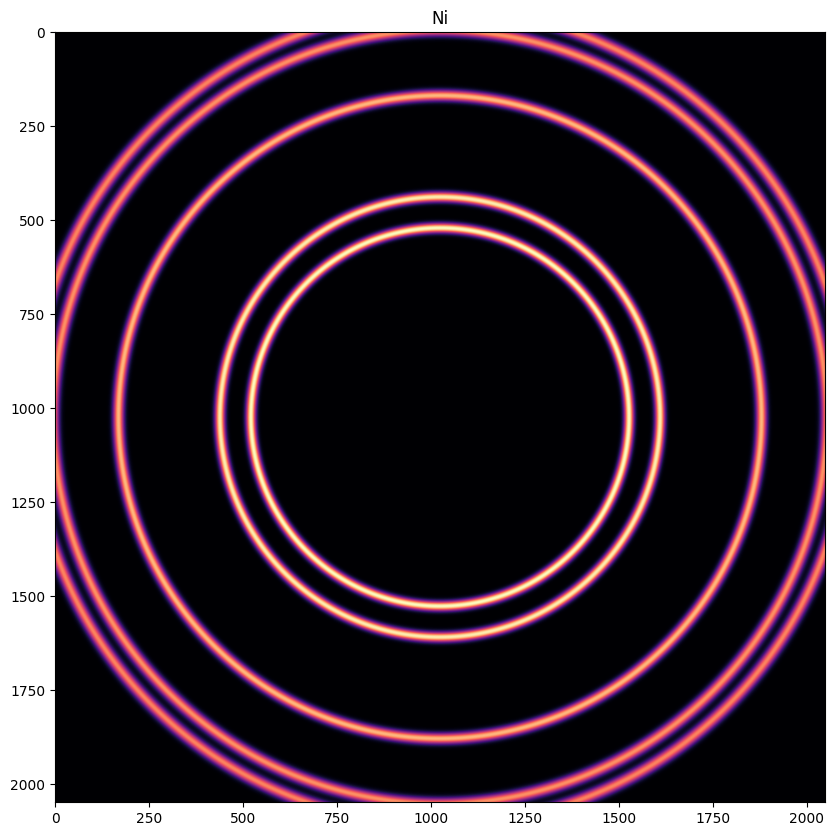

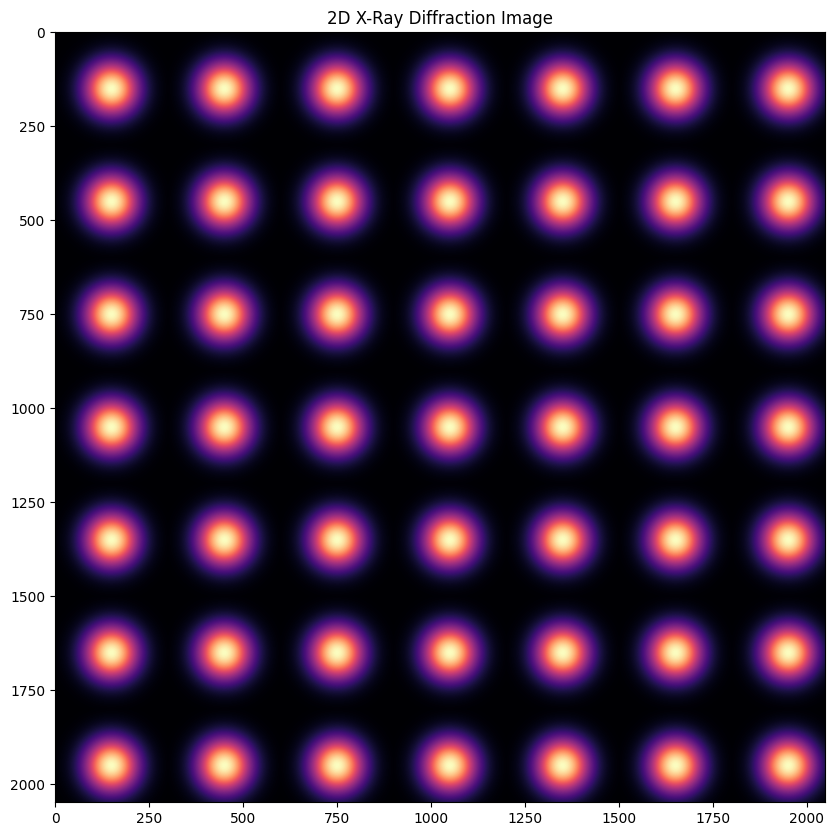

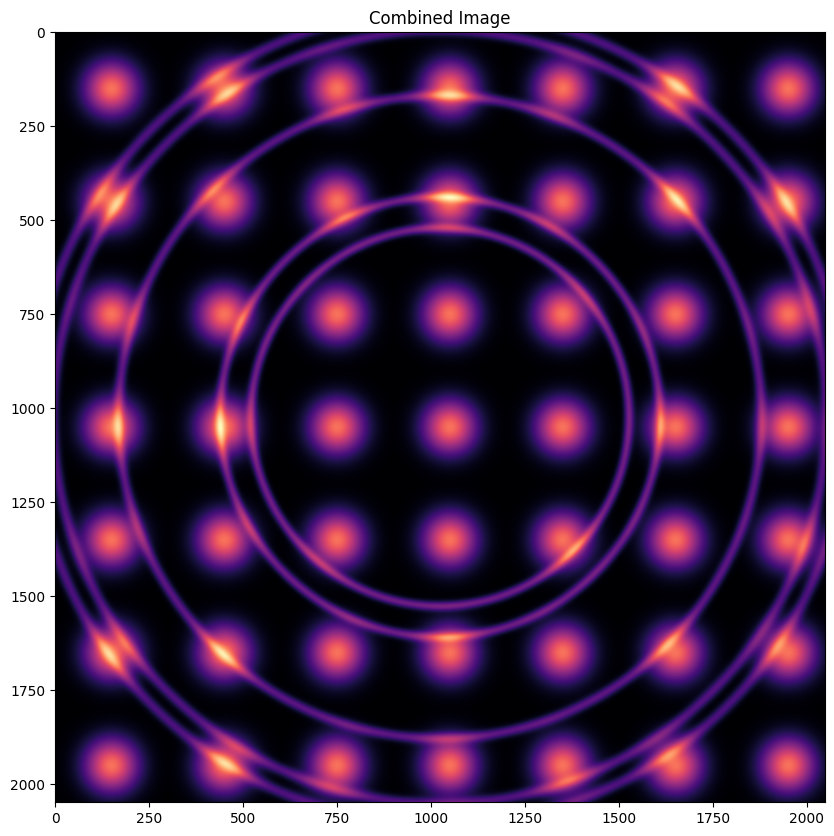

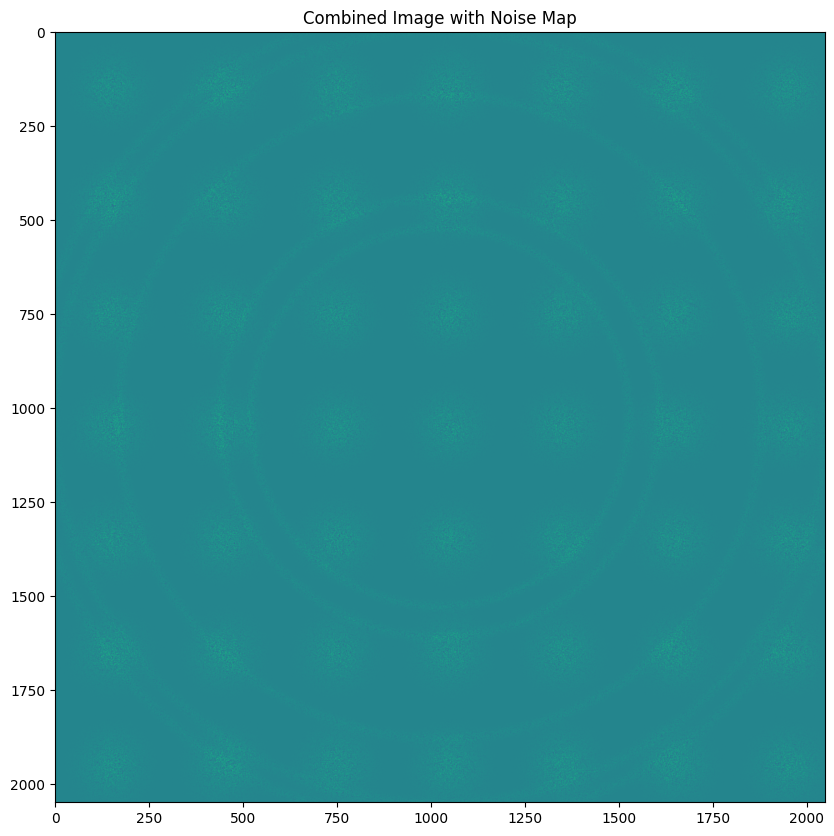

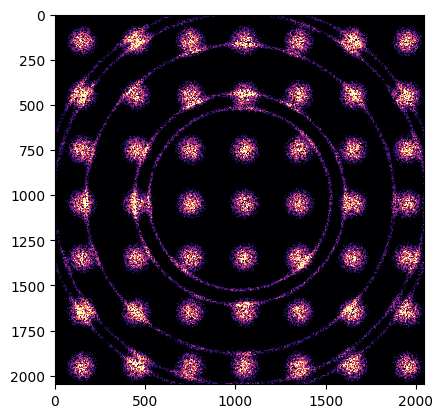

In [3]:
#For ring creation
isotropic_signal = sim.create_isotropic(.4, .5e-10, cmap = 'magma')
#For spot creation
anisotropic_signal = sim.create_anisotropic(25, 50, 300, 300, cmap = 'magma')
#combining signals 
thin_film = sim.combine_image(isotropic_signal, anisotropic_signal*2, cmap= 'magma')
#For noisy data
noisy_im = sim.generate_noisemap(thin_film);
plt.imshow(noisy_im, vmin = 1, vmax = 5, cmap = 'magma')

In [4]:
print("Combined image range:", np.min(thin_film), "to", np.max(thin_film))

Combined image range: 0.0002468196081733591 to 2.8363407449844638


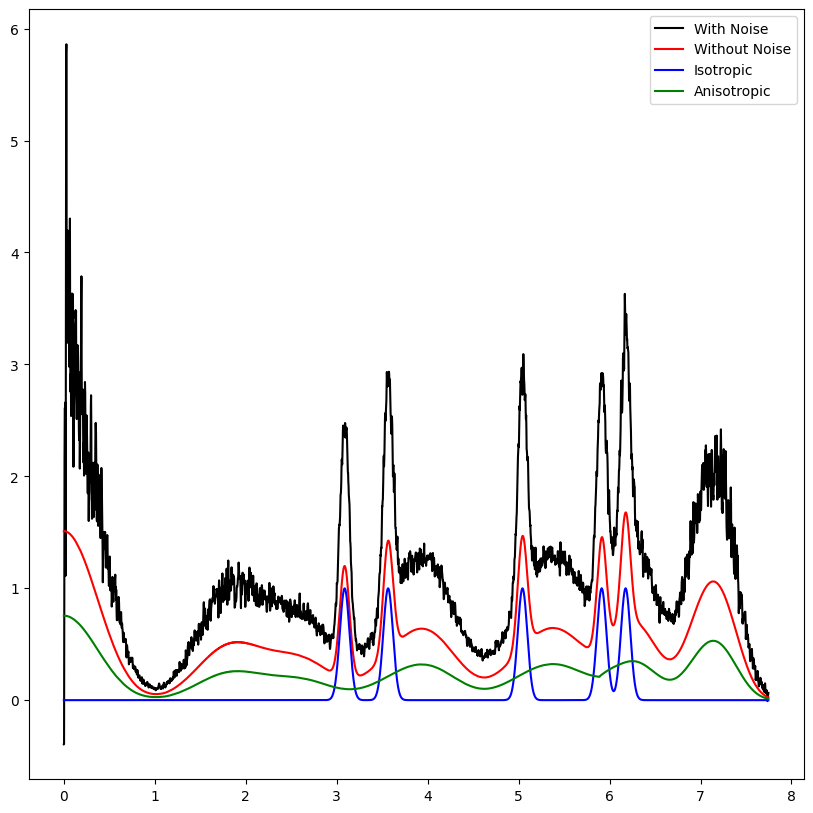

In [5]:
#using simdat2d to integrate the image
q_noisy, noisy_integrated_im = sim.integrate_image(noisy_im, .4, .5e-10, resolution = 3000)
q, integrated_im = sim.integrate_image(thin_film, .4, .5e-10, resolution = 3000)
q_reg, integrated_reg = sim.integrate_image(isotropic_signal, .4, .5e-10, resolution = 3000)
q_aniso, integrated_aniso = sim.integrate_image(anisotropic_signal, .4, .5e-10, resolution = 3000)

#matplotlib plot
plt.figure(figsize = (10,10))
plt.plot(q_noisy, noisy_integrated_im, c= 'k', label = 'With Noise')
plt.plot(q, integrated_im, c= 'r', label = 'Without Noise')
plt.plot(q_reg, integrated_reg, c= 'b', label = 'Isotropic')
plt.plot(q_aniso, integrated_aniso, c= 'g', label = 'Anisotropic')
plt.plot()
plt.legend()

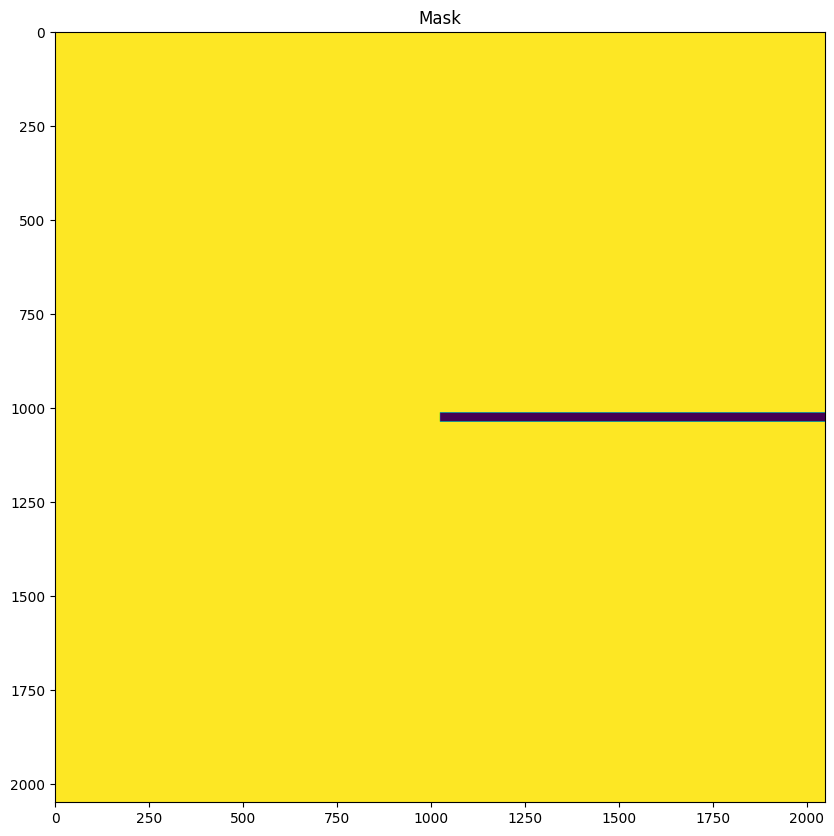

In [6]:
mask12 = sim.create_mask(thin_film, 12)

C:\Users\kelleymarisa\PythonProjects\SimDAT2D\SimDAT2D\SimDAT2D\SimDAT2D.py:349: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i] = I
C:\Users\kelleymarisa\PythonProjects\SimDAT2D\SimDAT2D\SimDAT2D\SimDAT2D.py:349: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i] = I
C:\Users\kelleymarisa\PythonProjects\SimDAT2D\SimDAT2D\SimDAT2D\SimDAT2D.py:349: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

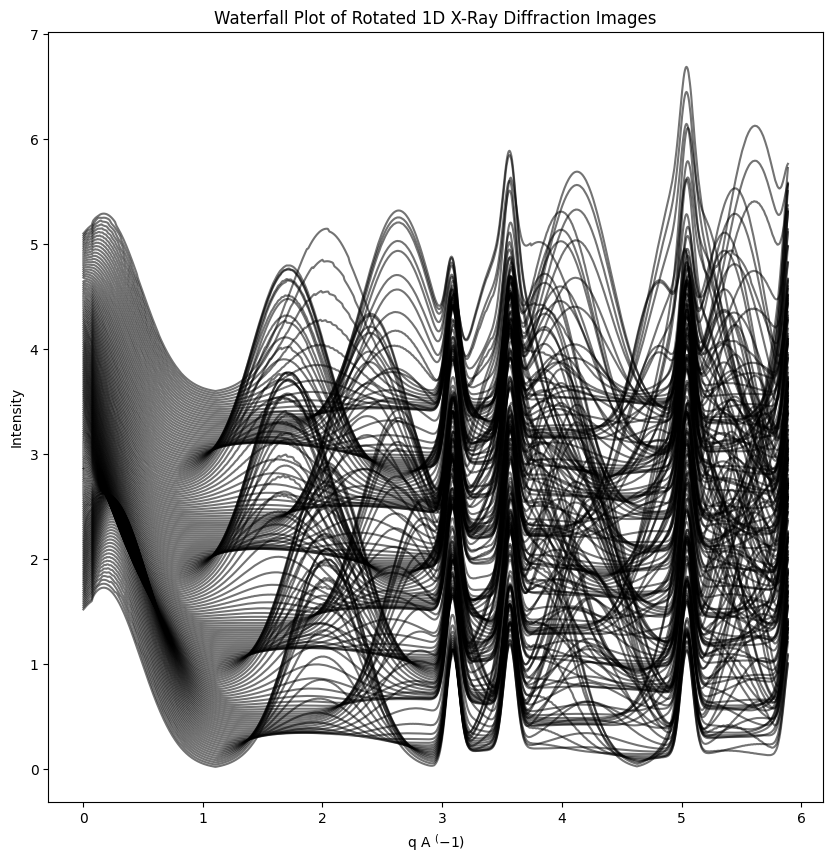

In [11]:
q, sim12_data = sim.rotate_and_integrate(thin_film, 2,.4, .5e-10, resolution = 1000, mask = mask12)

The beta-divergence is:  201.81354 %
 The final number of components used were 276 



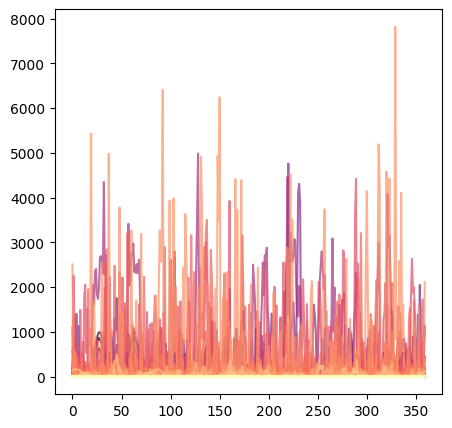

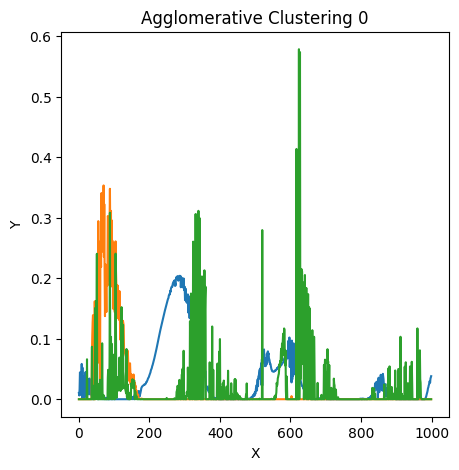

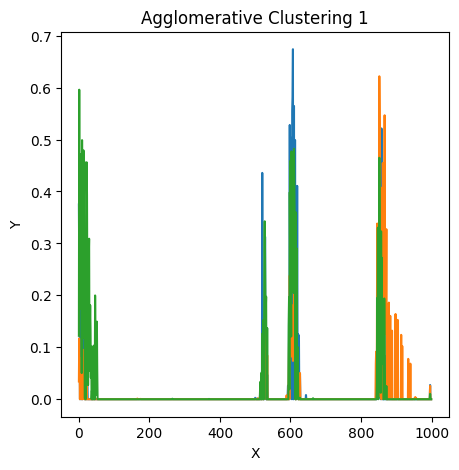

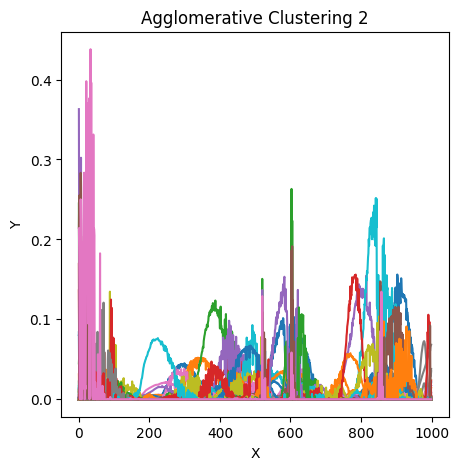

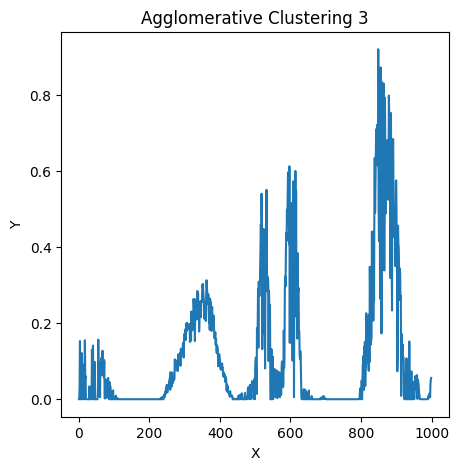

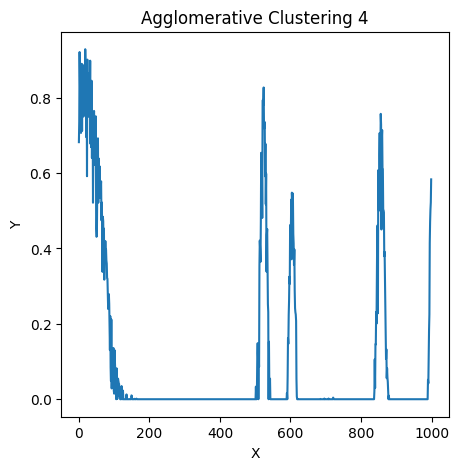

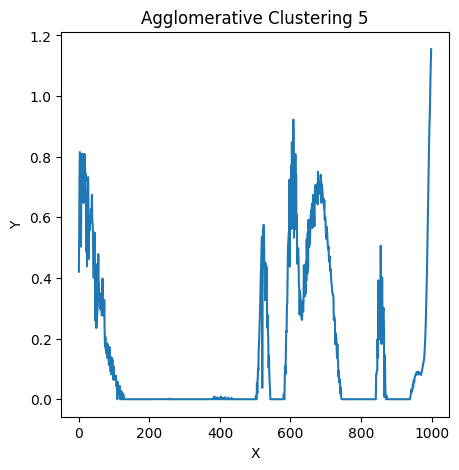

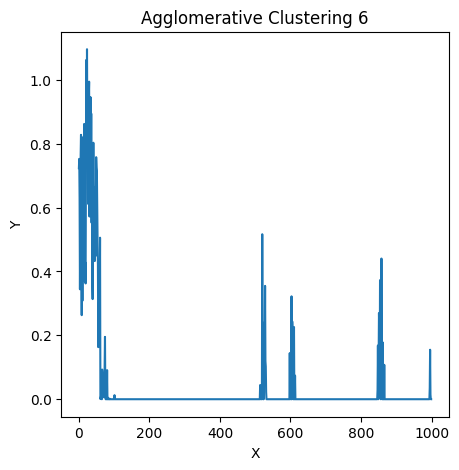

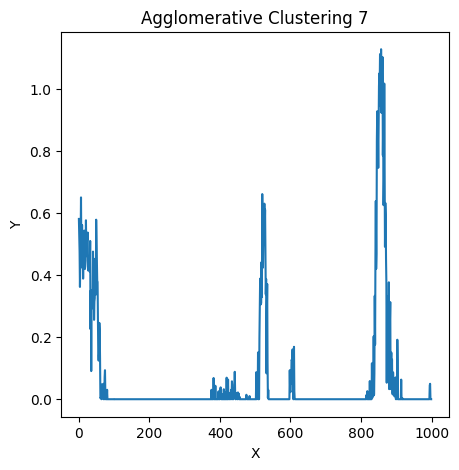

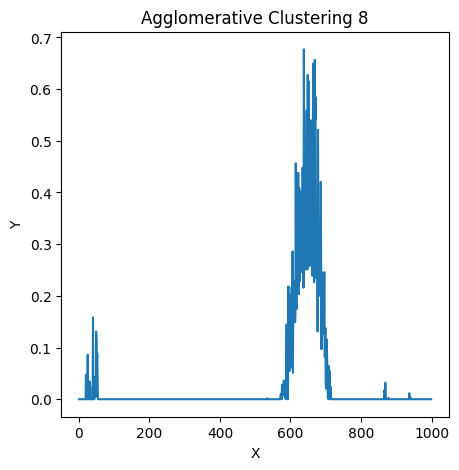

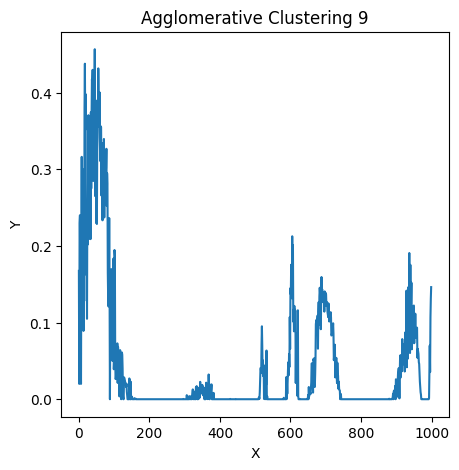

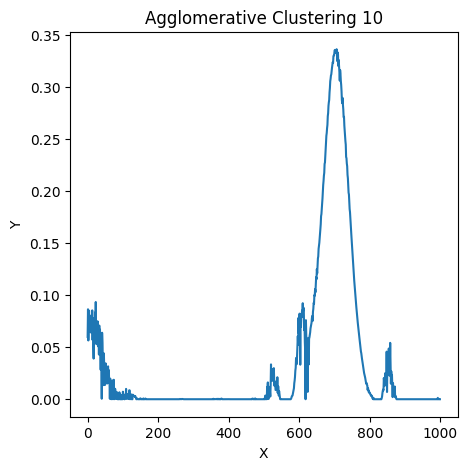

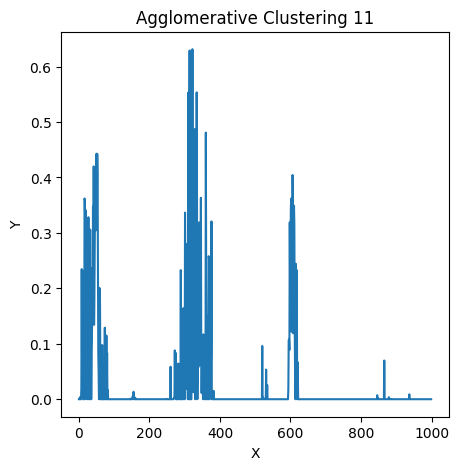

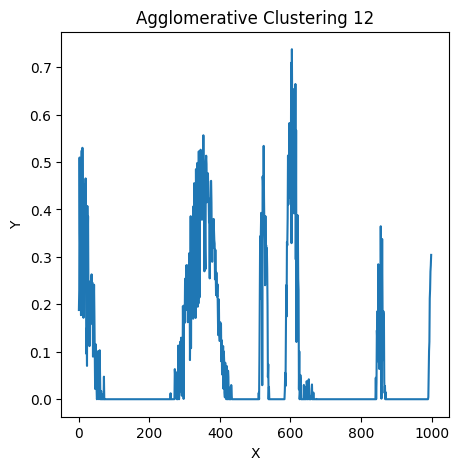

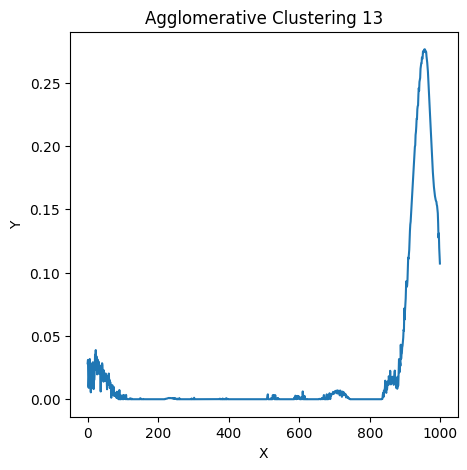

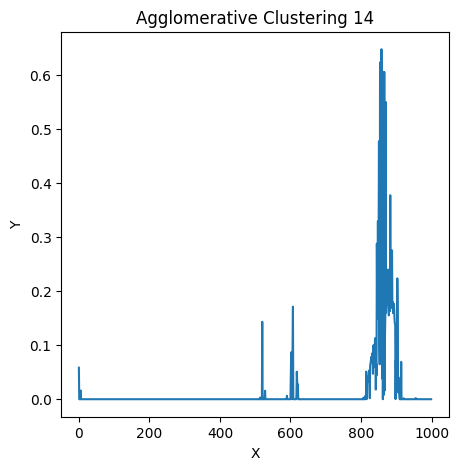

In [28]:
result = iso.run_nmfac(sim12_data, clusters = 15)

cluster_groups2 = {}
#for cluster_num in set(my_dict['Cluster_Number']):
#    cluster_groups2[cluster_num] = []
for i in range(15):  # Explicitly create 10 clusters
    if i < len(result):
        cluster_groups2[i] = result[i]
    else:
        print(f"Warning: Cluster {i} not found in results")

# Group the data based on cluster numbers
#for cluster_num, int_angle in zip(result['Cluster_Number'], result['Int_Angle']):
#    cluster_groups2[cluster_num].append(int_angle)
    
np.save('mask12.npy', cluster_groups2)

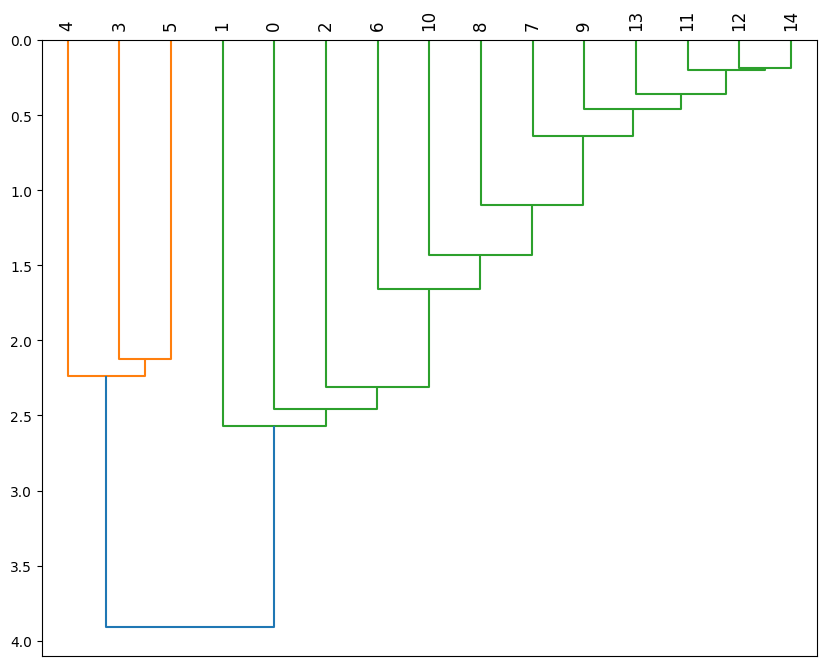

In [209]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, calinski_harabasz_score
# Convert dictionary values to a numpy array
# Method 1: Stack all values from the dictionary
data_for_linkage = np.vstack(list(cluster_groups2.values()))

# Or Method 2: If you want to use just the values
# data_for_linkage = np.array(list(cluster_groups2.values()))

# Now perform the linkage
Z = linkage(data_for_linkage, method='ward')

# Create the dendrogram
plt.figure(figsize=(10, 8))
dendrogram(Z, truncate_mode='lastp', p=15, leaf_rotation=90., 
          leaf_font_size=12., show_contracted=True, orientation='bottom')
plt.show()

In [30]:
# Check data in dendrogram
print("Shape of data:", data_for_linkage.shape)
print("Data type:", data_for_linkage.dtype)
print("Number of clusters:", len(cluster_groups2))
print("Cluster keys:", cluster_groups2.keys())

Shape of data: (15, 1000)
Data type: float32
Number of clusters: 15
Cluster keys: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])


In [36]:
def create_mask_for_tiff(tiff_path, width):
    """
    This function creates a mask for the azimuthal integrator from a TIFF file.
    
    Parameters:
        tiff_path (str): Path to the TIFF file
        width (int): The width of the line of interest
    """
    # Import tiff file
    from tifffile import imread
    image = imread(tiff_path)
    
    # Get the center point (assuming square image)
    center = image.shape[0] // 2
    
    # Create the mask
    mask = np.ones_like(image)
    mask[center-width:center+width, center:] = 0
    
    # Display the mask
    plt.figure(figsize=(8, 8))
    plt.imshow(mask, cmap='viridis')
    plt.title("Mask")
    plt.show()
    
    return mask

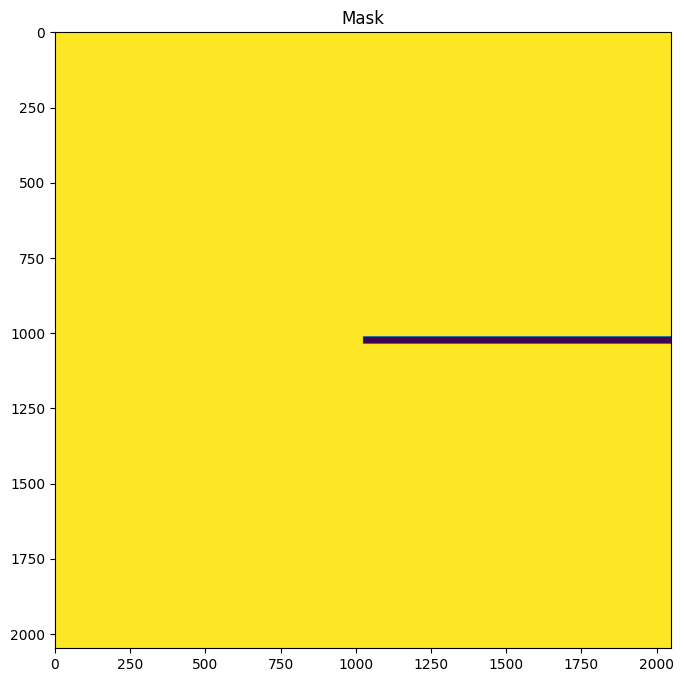

In [57]:
GST_9 = r'C:\Users\kelleymarisa\UFL Dropbox\Marisa Kelley\DNA&MDKShare\copy_data_isodat\perkin\da_9_cryst_GST_SiO2-00009\da_9_cryst_GST_SiO2-00009.tiff'
mask_12 = create_mask_for_tiff(GST_9, 12)

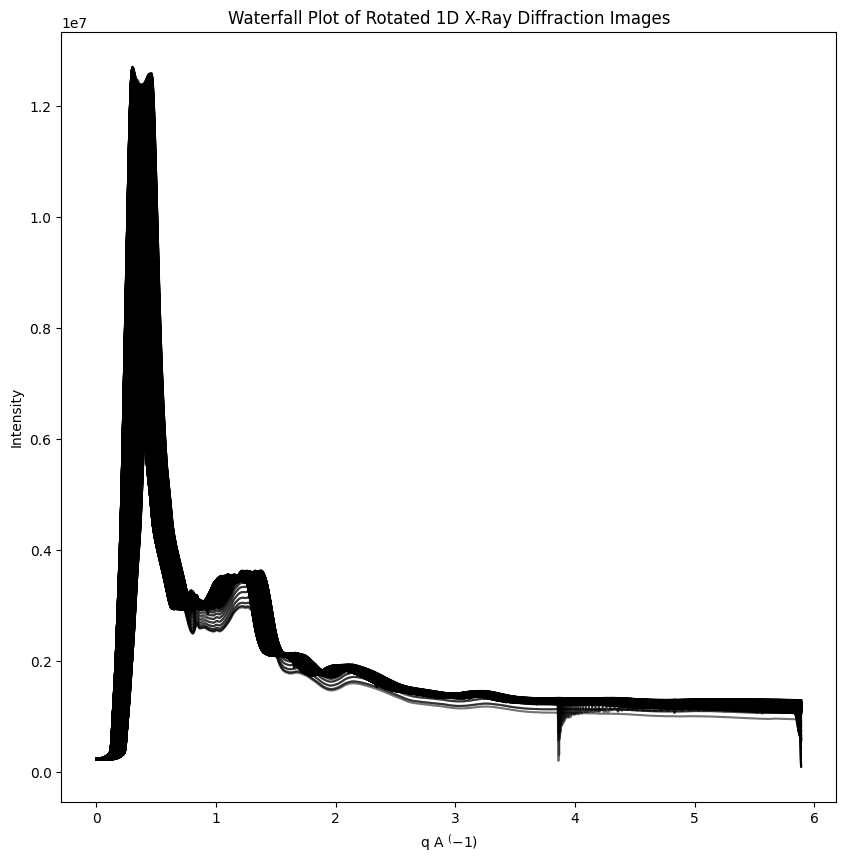

In [41]:
from tifffile import imread
GST_9_image = imread(GST_9)  # the path to your file
q, GST_9_data = sim.rotate_and_integrate(GST_9_image, 1, .4, .5e-10, resolution = 1000, mask = mask_12)

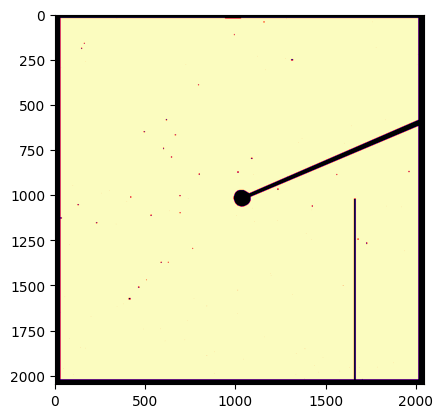

In [103]:
manual_mask_path = r'C:\Users\kelleymarisa\UFL Dropbox\Marisa Kelley\DNA&MDKShare\copy_data_isodat\perkin\manual_mask.npy'
manual_mask = np.load(manual_mask_path)
# Invert the mask (0s become 1s and 1s become 0s)
inverted_mask = 1 - manual_mask  # or: np.logical_not(mask_12).astype(float)
#check mask
plt.imshow(inverted_mask, cmap = 'magma')
plt.show()

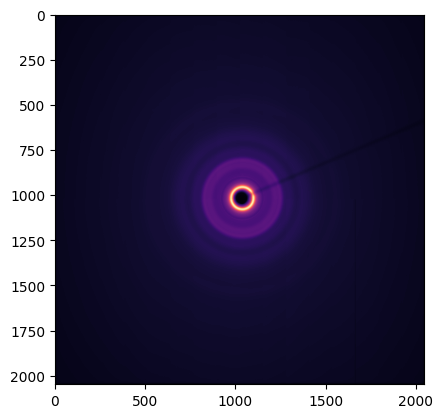

In [101]:
#check image
plt.imshow(GST_9_image, cmap = 'magma')
plt.show()

In [51]:
# Check values
print("TIFF image range:", np.min(GST_9_image), "to", np.max(GST_9_image))
print("Mask range:", np.min(manual_mask), "to", np.max(manual_mask))
print("Mask 12 range:", np.min(mask_12), "to", np.max(mask_12))

TIFF image range: -19008.0 to 12795088.0
Mask range: 0 to 1
Mask 12 range: 0.0 to 2.0


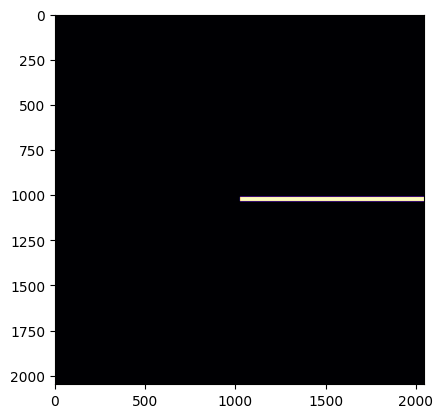

In [81]:
mask_12_inverted = 1 - mask_12
plt.imshow(mask_12_inverted, cmap = 'magma')
plt.show()

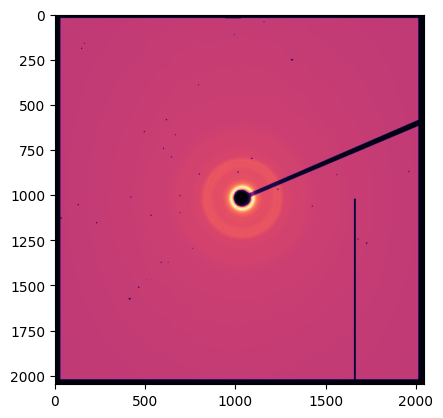

In [104]:
# Scale mask to match image range
scaled_mask = inverted_mask * np.max(GST_9_image)
combined_image = GST_9_image + scaled_mask
plt.imshow(combined_image, cmap = 'magma')
plt.show()

In [66]:
# Check values
print("TIFF image range:", np.min(GST_9_image), "to", np.max(GST_9_image))
print("Mask range:", np.min(scaled_mask), "to", np.max(scaled_mask))
print("Combined image range:", np.min(combined_image), "to", np.max(combined_image))

TIFF image range: -19008.0 to 12795088.0
Mask range: 0.0 to 12795088.0
Combined image range: -19008.0 to 25590176.0


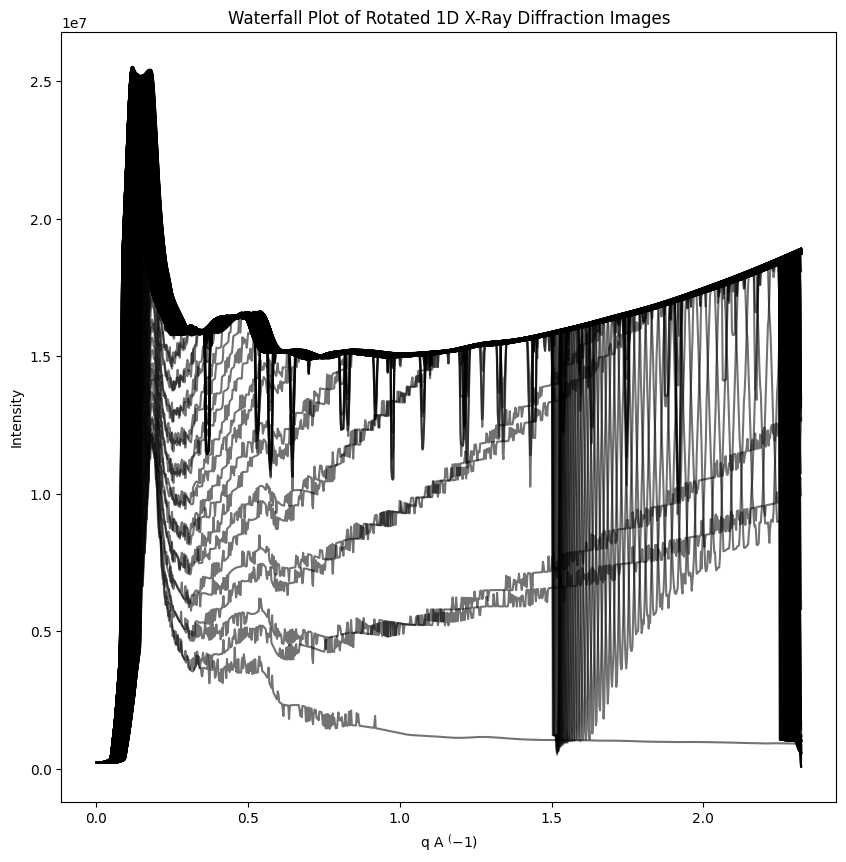

In [105]:
q, GST_9_data_manual = sim.rotate_and_integrate(combined_image, 1, .4179, 1.222e-10, resolution = 1000, mask = mask_12)

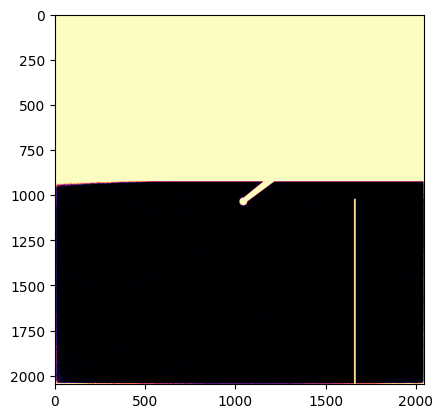

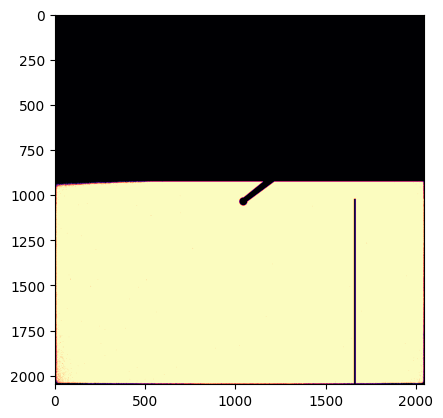

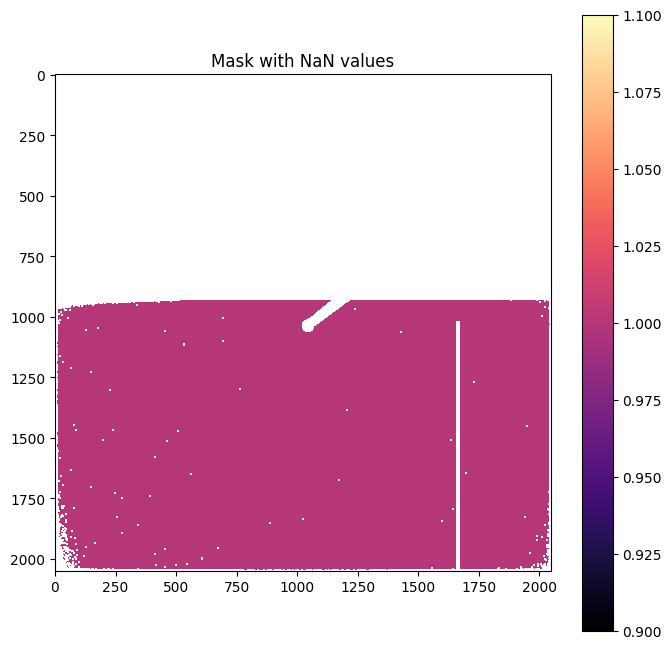

In [146]:
gz_mask_path = r'C:\Users\kelleymarisa\UFL Dropbox\Marisa Kelley\DNA&MDKShare\copy_data_isodat\p21p1\Masks\mask_integration.npy'
gz_mask = np.load(gz_mask_path)
plt.imshow(gz_mask, cmap = 'magma')
plt.show()
# Invert the mask (0s become 1s and 1s become 0s)
gz_inverted_mask = 1 - gz_mask  # or: np.logical_not(mask_12).astype(float)
#check mask
plt.imshow(gz_inverted_mask, cmap = 'magma')
plt.show()

# turned zeros to NaN in invertedpyfai mask
# Convert zeros to NaN
gz_mask_with_nan = gz_inverted_mask.astype(float)  # Convert to float type first since NaN requires float
gz_mask_with_nan[gz_inverted_mask == 0] = np.nan
# Visualize to verify
plt.figure(figsize=(8, 8))
plt.imshow(gz_mask_with_nan, cmap='magma')
plt.title('Mask with NaN values')
plt.colorbar()
plt.show()


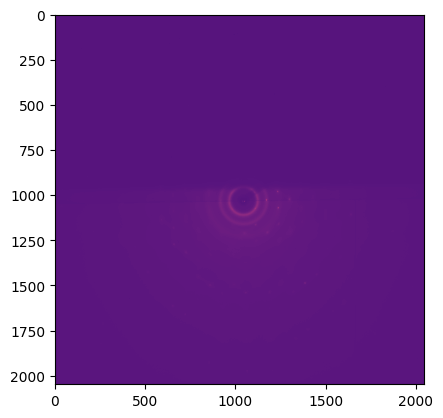

In [87]:
GST_6C_real_0035 = r'C:\Users\kelleymarisa\UFL Dropbox\Marisa Kelley\DNA&MDKShare\copy_data_isodat\p21p1\gits_a_GST_6C_real\gits_a_GST_6C_real_45_mdeg-00035.tif'
GST_6C_real_0035_image = imread(GST_6C_real_0035)
#check image
plt.imshow(GST_6C_real_0035_image, cmap = 'magma')
plt.show()


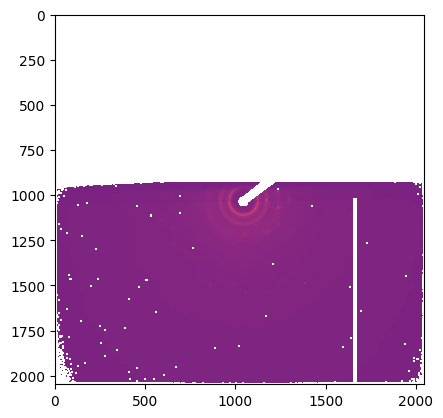

In [149]:
# Scale mask to match image range
#gz_scaled_mask = gz_mask_with_nan * np.max(GST_6C_real_0035_image)
gz_combined_image = GST_6C_real_0035_image + gz_mask_with_nan
plt.imshow(gz_combined_image, cmap = 'magma')
plt.show()

In [79]:
# Check values
print("TIFF image range:", np.min(GST_6C_real_0035_image), "to", np.max(GST_6C_real_0035_image))
print("Mask range:", np.min(gz_scaled_mask), "to", np.max(gz_scaled_mask))
print("Combined image range:", np.min(gz_combined_image), "to", np.max(gz_combined_image))

TIFF image range: -432640.0 to 1193701.0
Mask range: 0.0 to 1193701.0
Combined image range: -349477.0 to 1998627.0


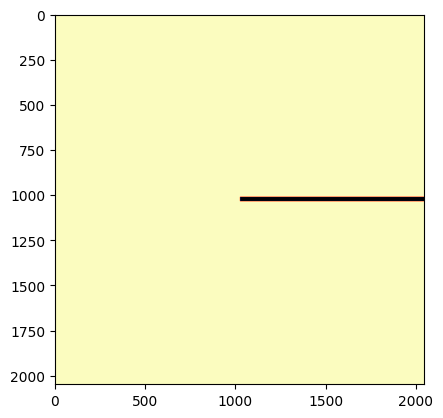

In [88]:
mask_12 = mask_12
plt.imshow(mask_12, cmap = 'magma')
plt.show()

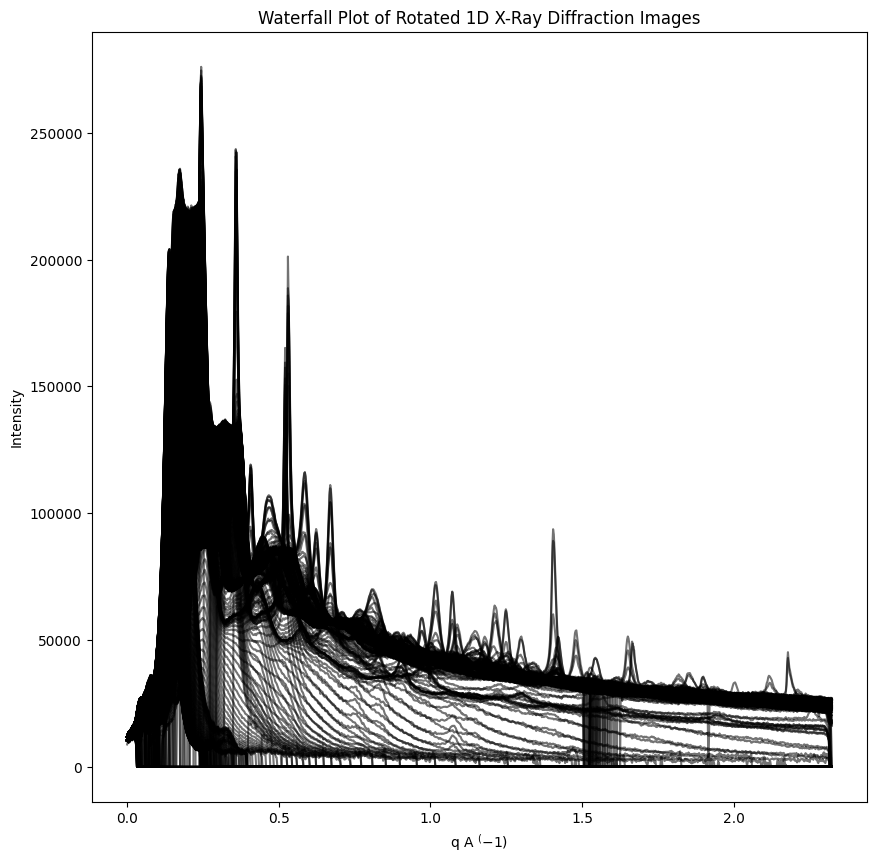

In [150]:
q, GST_6C_real_0035_data = sim.rotate_and_integrate(gz_combined_image, 1, .4179, 1.222e-10, resolution = 1000, mask = mask_12)
# numpy turn NaN into mean of pixels next to it

In [155]:
def fill_nan_with_neighbor_mean(image):
    """
    Fill NaN values with the mean of neighboring non-NaN pixels
    """
    # Create a mask of NaN values
    # nan_mask = np.isnan(image)
    
    # Create a copy of the image to work with
    filled_image = np.copy(image)
    
    # np.where returns a tuple of arrays containing the row and column indices
    nan_y, nan_x = np.where(np.isnan(filled_image))
    
    # Loop through each NaN pixel
    for y, x in zip(nan_y, nan_x):
        # Define a window around the NaN pixel (5x5 window)
        y_start = max(0, y - 2)  # Ensure we don't go below 0
        y_end = min(image.shape[0], y + 3)  # Ensure we don't exceed image height
        x_start = max(0, x - 2)  # Ensure we don't go below 0
        x_end = min(image.shape[1], x + 3)  # Ensure we don't exceed image width
        
        # Extract the window of pixels
        window = filled_image[y_start:y_end, x_start:x_end]
        
        # Calculate mean of non-NaN values in the window
        mean_value = np.nanmean(window)
        
        # Replace NaN with the calculated mean
        filled_image[y, x] = mean_value
    
    return filled_image

gz_filled_with_mean = fill_nan_with_neighbor_mean(gz_combined_image)

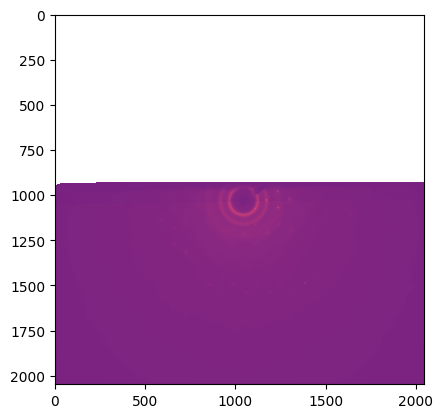

In [156]:
plt.imshow(gz_filled_with_mean, cmap = 'magma')
plt.show()

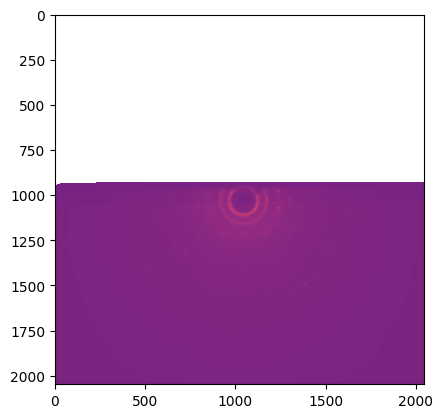

In [157]:
gz_combined_image_mean = GST_6C_real_0035_image + gz_filled_with_mean
plt.imshow(gz_combined_image_mean, cmap = 'magma')
plt.show()

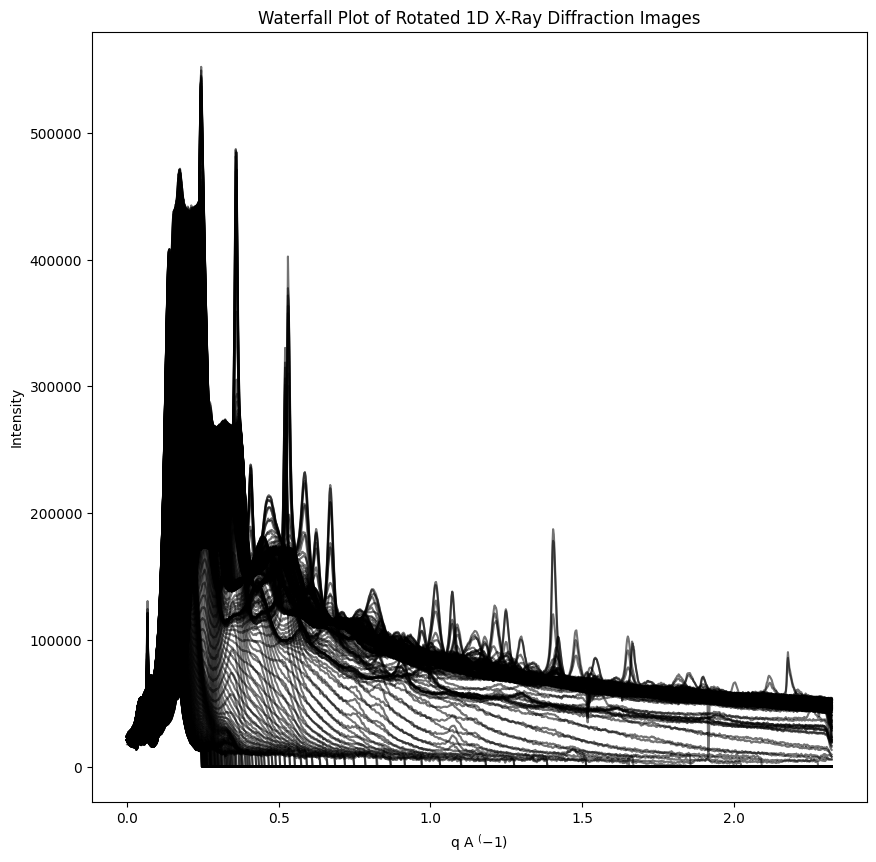

In [160]:
q, GST_6C_real_0035_data_mean = sim.rotate_and_integrate(gz_combined_image_mean, 1, .4179, 1.222e-10, resolution = 1000, mask = mask_12)

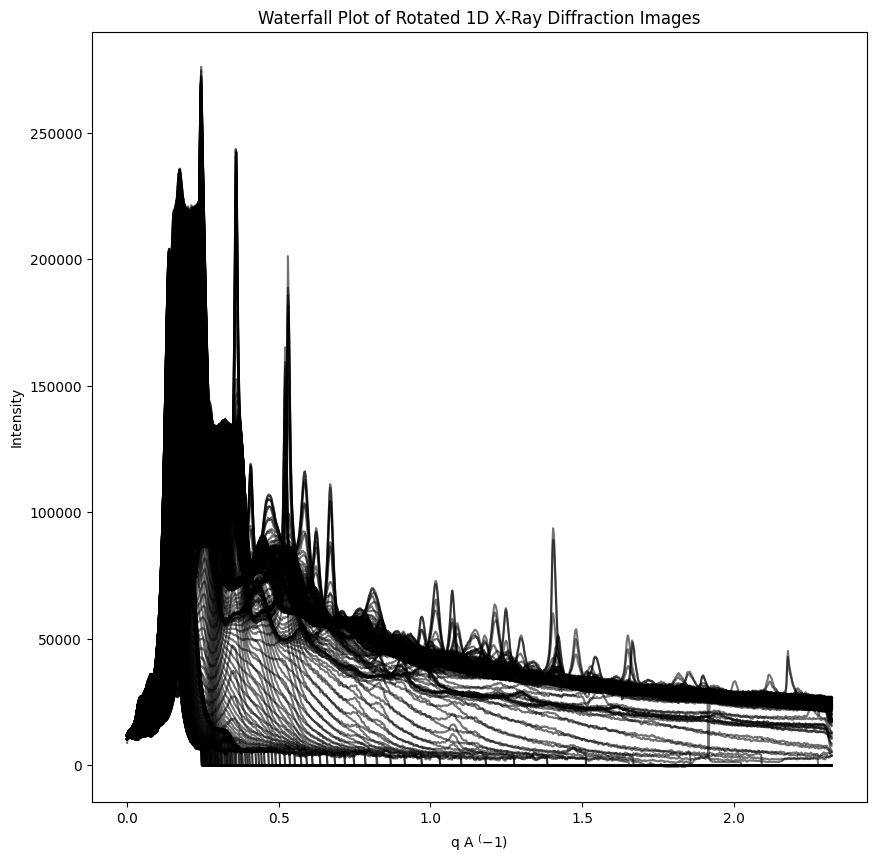

In [176]:
q, GST_6C_real_0035_data_nanmean = sim.rotate_and_integrate(gz_filled_with_mean, 1, .4179, 1.222e-10, resolution = 1000, mask = mask_12)

In [177]:
print("1D data range:", np.min(GST_6C_real_0035_data_mean), "to", np.max(GST_6C_real_0035_data_mean))
GST_6C_real_0035_data_mean_adj = GST_6C_real_0035_data_mean + 36.75969
print("1D data range:", np.min(GST_6C_real_0035_data_mean_adj), "to", np.max(GST_6C_real_0035_data_mean_adj))

1D data range: -36.75969 to 551943.1
1D data range: 0.0 to 551979.9


In [194]:
#clip zero instead
print("1D data range:", np.min(GST_6C_real_0035_data_nanmean), "to", np.max(GST_6C_real_0035_data_nanmean))
GST_6C_real_0035_data_nanmean_adj = GST_6C_real_0035_data_nanmean + 566.9972
print("1D data range:", np.min(GST_6C_real_0035_data_nanmean_adj), "to", np.max(GST_6C_real_0035_data_nanmean_adj))

1D data range: -566.9972 to 275972.06
1D data range: 0.0 to 276539.06


The beta-divergence is:  525237600.0 %
 The final number of components used were 29 



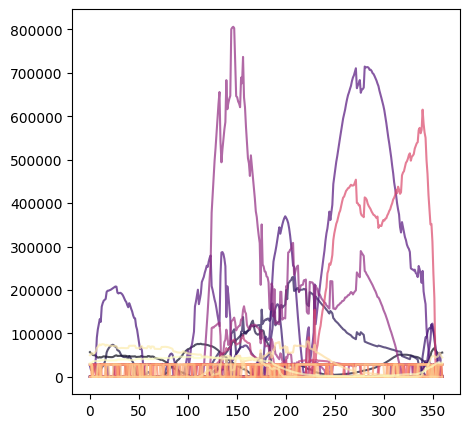

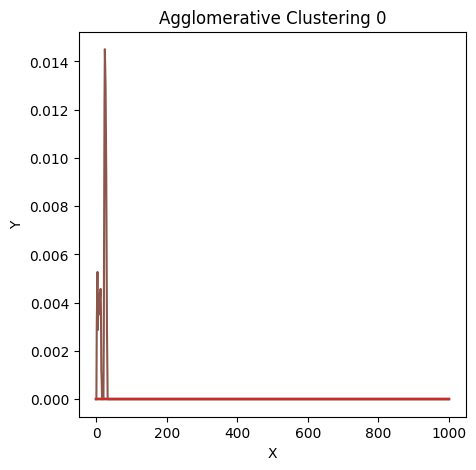

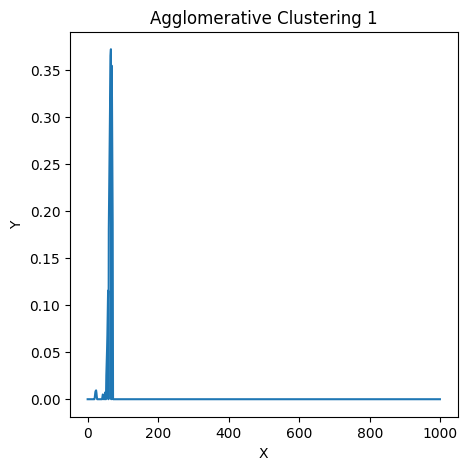

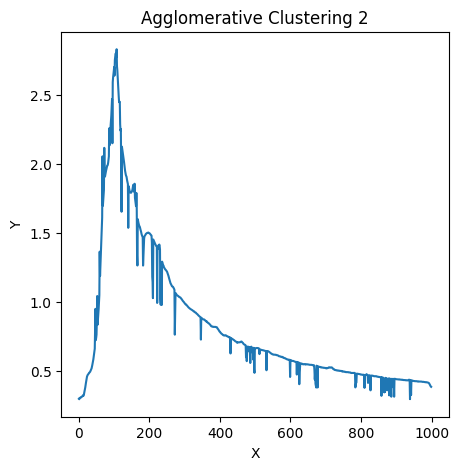

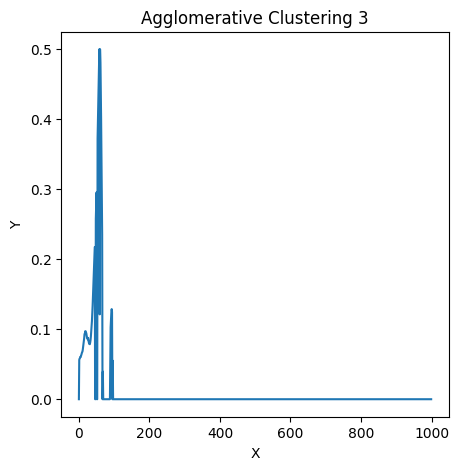

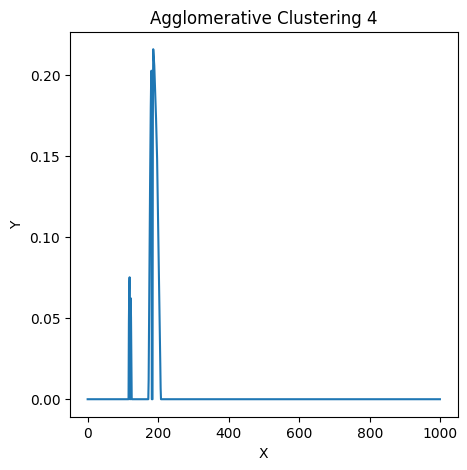

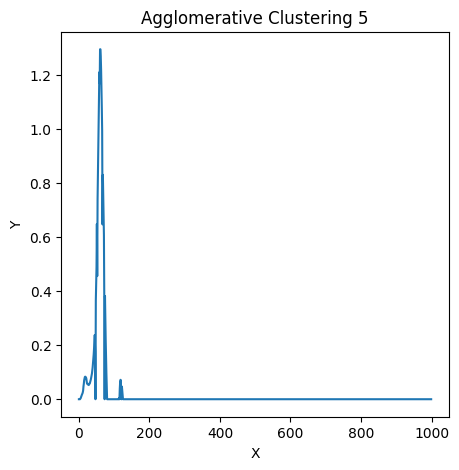

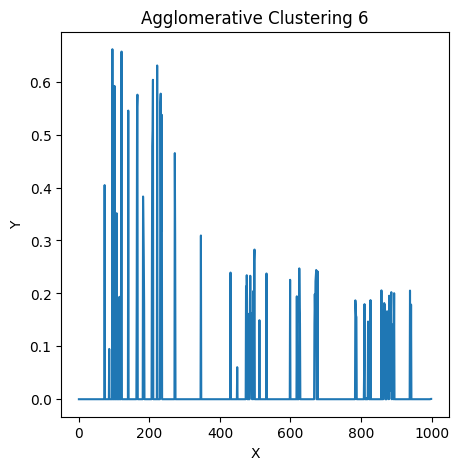

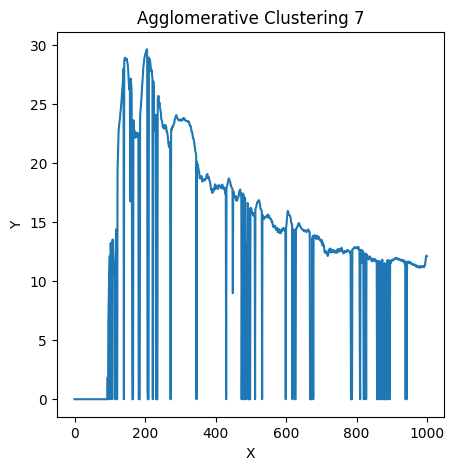

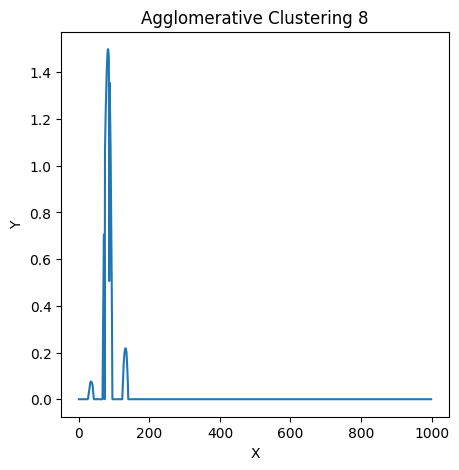

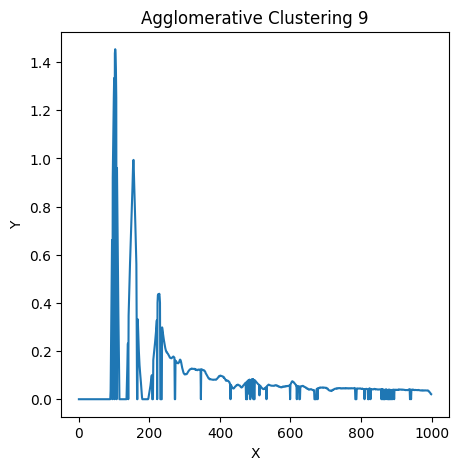

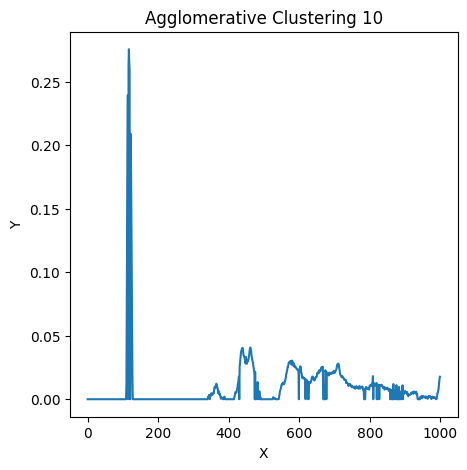

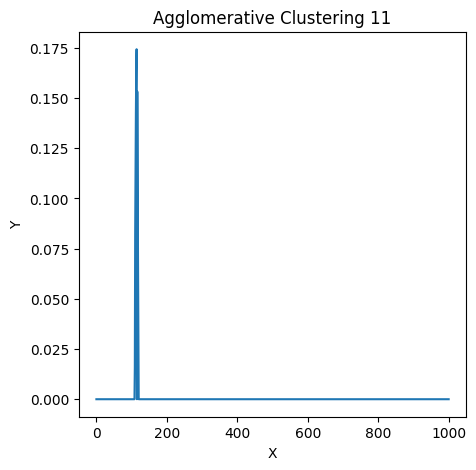

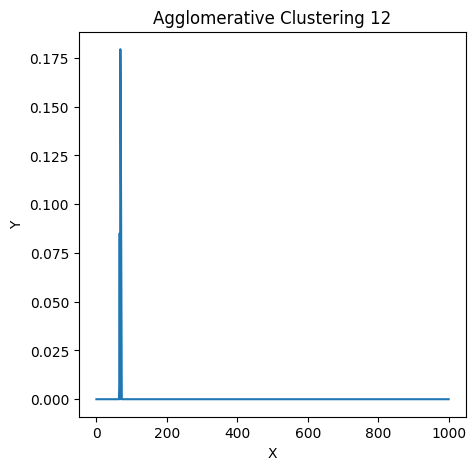

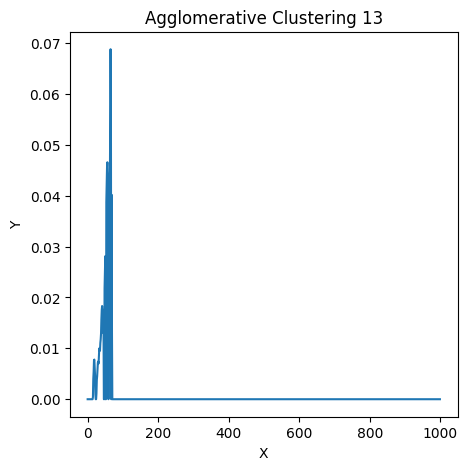

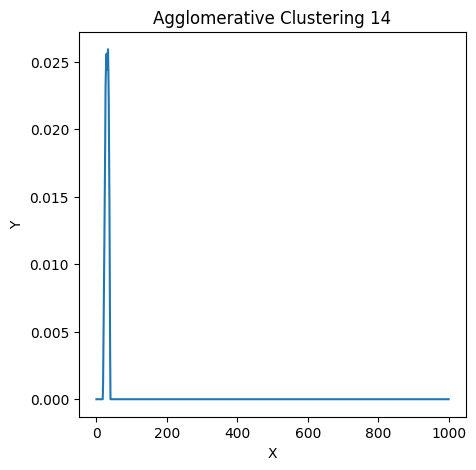

In [195]:
result = iso.run_nmfac(GST_6C_real_0035_data_nanmean_adj, clusters = 15)

cluster_groups_mean = {}
#for cluster_num in set(my_dict['Cluster_Number']):
#    cluster_groups2[cluster_num] = []
for i in range(15):  # Explicitly create n clusters
    if i < len(result):
        cluster_groups_mean[i] = result[i]
    else:
        print(f"Warning: Cluster {i} not found in results")

# Group the data based on cluster numbers
#for cluster_num, int_angle in zip(result['Cluster_Number'], result['Int_Angle']):
#    cluster_groups2[cluster_num].append(int_angle)
    
np.save('mask_nan_mean.npy', cluster_groups_mean)

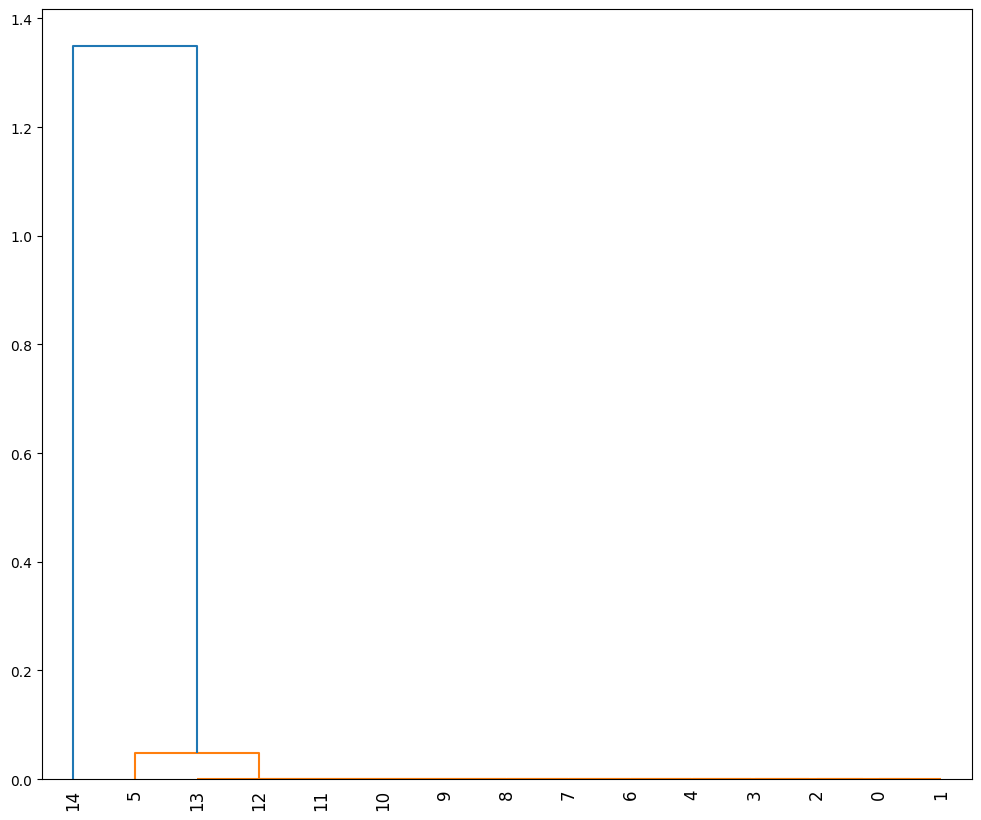

In [196]:
# Convert dictionary values to a numpy array
# Method 1: Stack all values from the dictionary
data_for_linkage = np.vstack(list(cluster_groups_mean.values()))

# Or Method 2: If you want to use just the values
# data_for_linkage = np.array(list(cluster_groups2.values()))

# Now perform the linkage
Z = linkage(data_for_linkage, method='ward')

# Create the dendrogram
plt.figure(figsize=(12, 10))
dendrogram(Z, truncate_mode='lastp', p=15, leaf_rotation=90., 
          leaf_font_size=12., show_contracted=True)
plt.show()

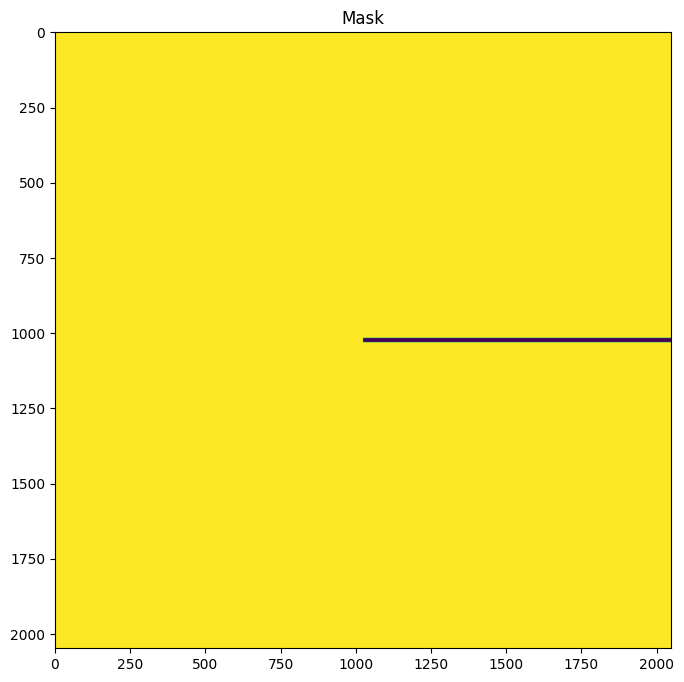

In [197]:
mask_7 = create_mask_for_tiff(GST_6C_real_0035, 7)

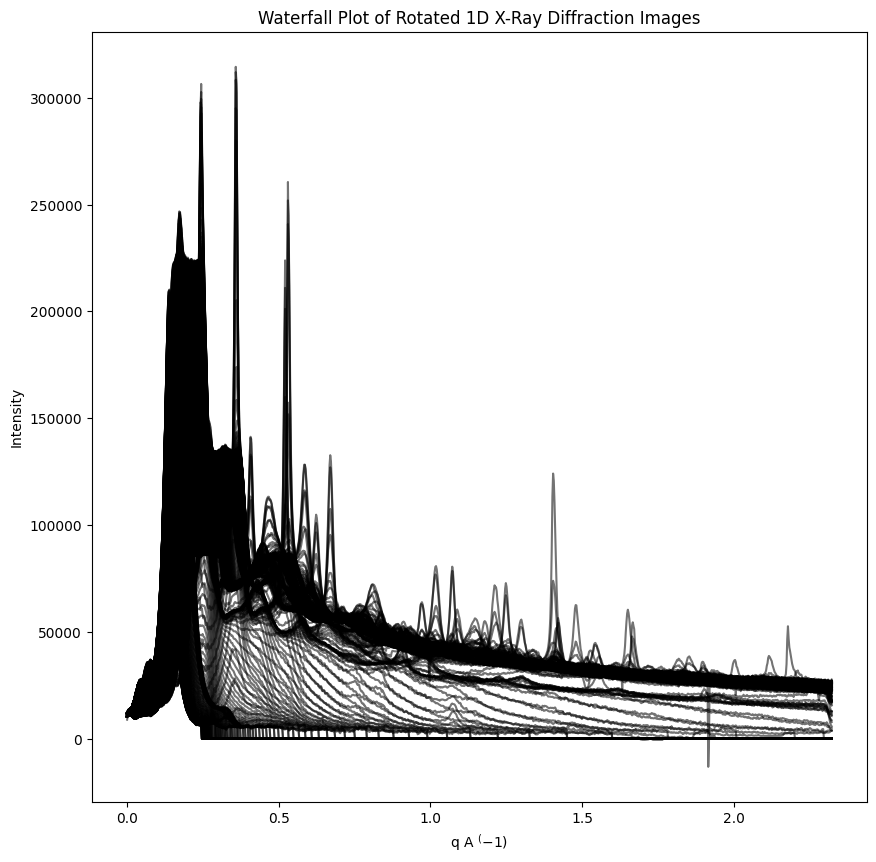

In [198]:
q, GST_6C_real_0035_nanmean_mask7 = sim.rotate_and_integrate(gz_filled_with_mean, 1, .4179, 1.222e-10, resolution = 1000, mask = mask_7)

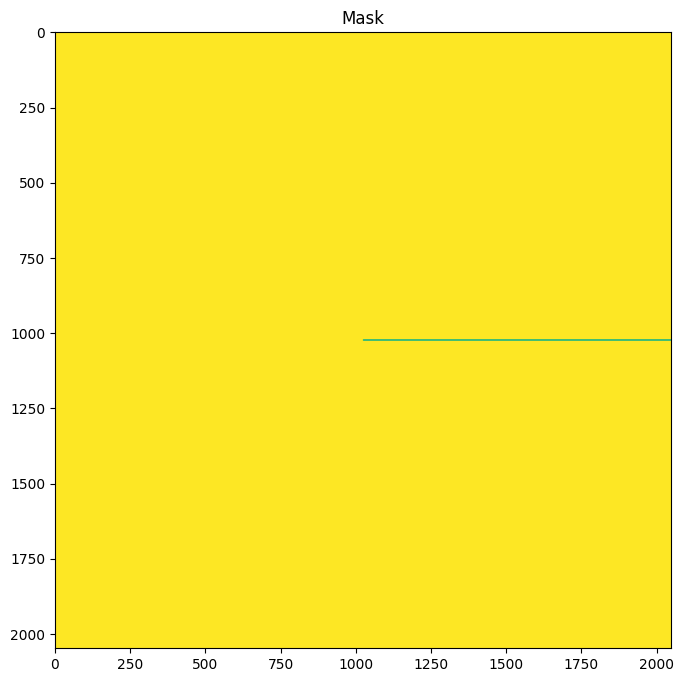

In [199]:
mask_1 = create_mask_for_tiff(GST_6C_real_0035, 1)

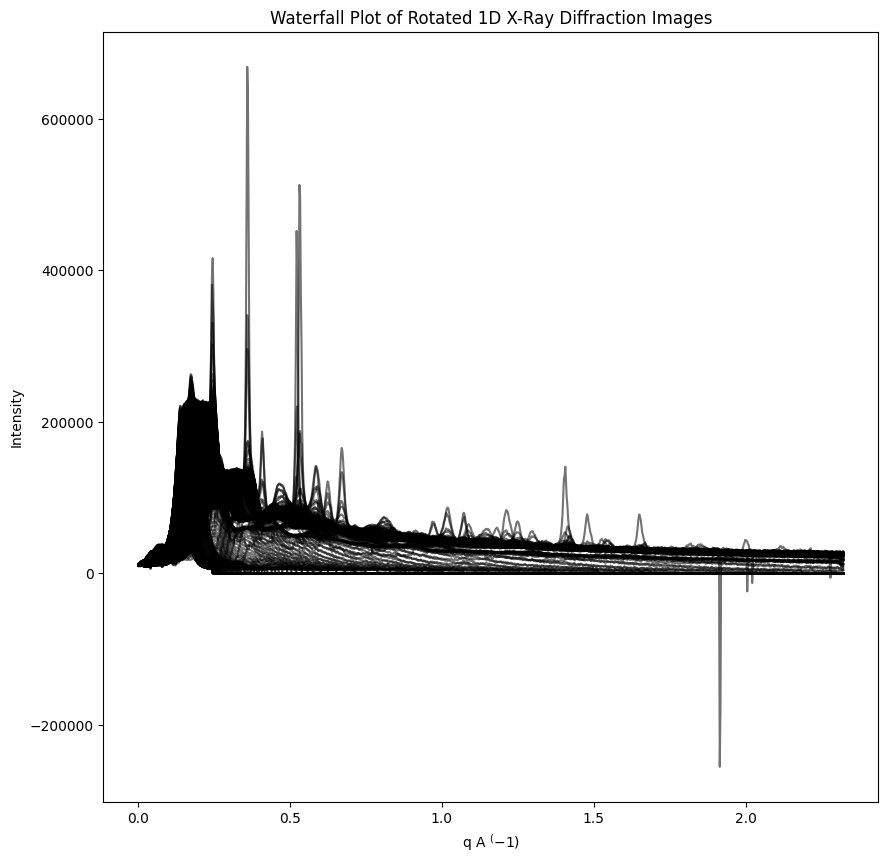

In [201]:
q, GST_6C_real_0035_nanmean_mask1 = sim.rotate_and_integrate(gz_filled_with_mean, 1, .4179, 1.222e-10, resolution = 1000, mask = mask_1)

In [204]:
def rotate_and_integrate(combined_image, angle_of_rotation, distance, wavelength, resolution = 3000, mask = None):
    """
    This function takes the combined image, the mask, the distance, the wavelength, and the resolution of integration, and rotates the combined image by a user specified angle amount, if the angle specified is 1, the result will be 360 integrations of the combined image, each integration will be rotated by 1 degree.
    
    Parameters:
        combined_image (2D array): The image of the combined spots and calibration.
        angle_of_rotation (int): The angle of rotation.
        distance (float): The distance from the detector to the sample.
        wavelength (float): The wavelength of the x-rays.
        resolution (int): The resolution of the integration.
        mask (2D array): The mask to use for the integration.
    """
    
    import pandas as pd 
    
    #create a dataframe to store the 1D integrations
    df = pd.DataFrame()
    
    #create a loop that rotates the combined image by the user specified angle amount and integrates the image
    for i in range(0, 180, angle_of_rotation):
        #rotate the mask for the combined image
        rotated_image = sim.image_rotation(combined_image, i);
    
        
        #integrate the rotated image
        q, I = sim.integrate_image(rotated_image, distance, wavelength, resolution, mask, show = False);
        
        #add the 1D integration to the dataframe
        df[i] = I
        
        #create a waterfall plot of the 1D integrations, where each dataset is moved up on the y axis by a multiple of .5
    plt.figure(figsize=(10, 10))
    for j in range(0, 180, angle_of_rotation):
            plt.plot(q, (df[j]+ j*.01), alpha = .55, c = 'black')
    plt.xlabel('q A $^(-1)$')
    plt.ylabel('Intensity')
    plt.title("Waterfall Plot of Rotated 1D X-Ray Diffraction Images")
    plt.show()        
    return q, df


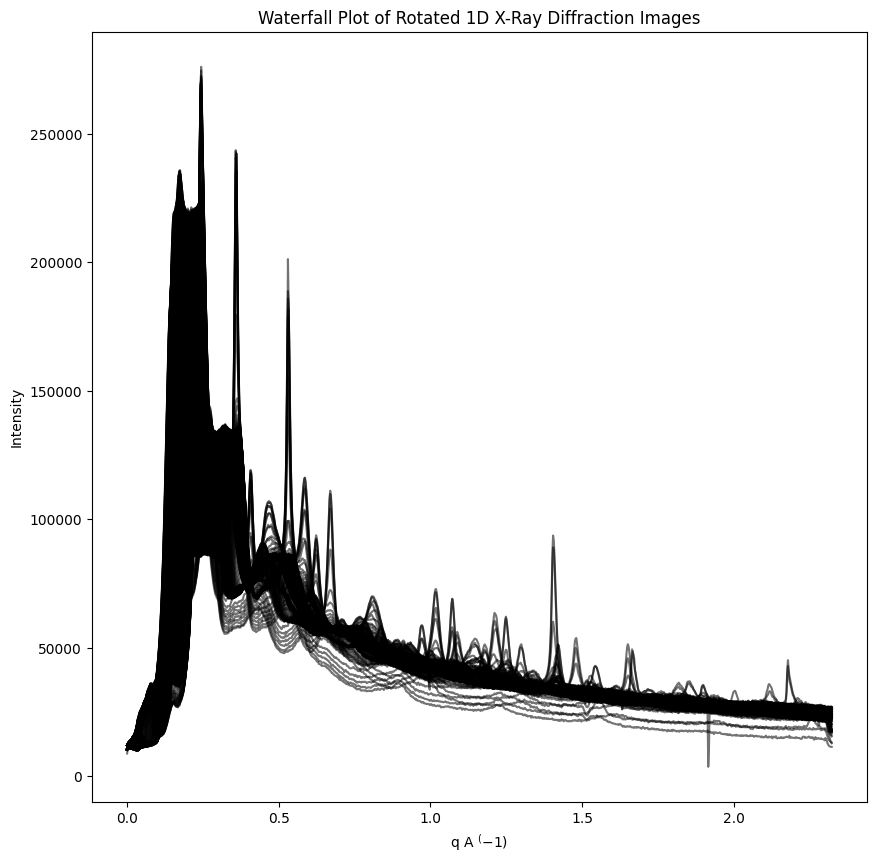

In [205]:
q, GST_6C_real_0035_data_nanmean = rotate_and_integrate(gz_filled_with_mean, 1, .4179, 1.222e-10, resolution = 1000, mask = mask_12)

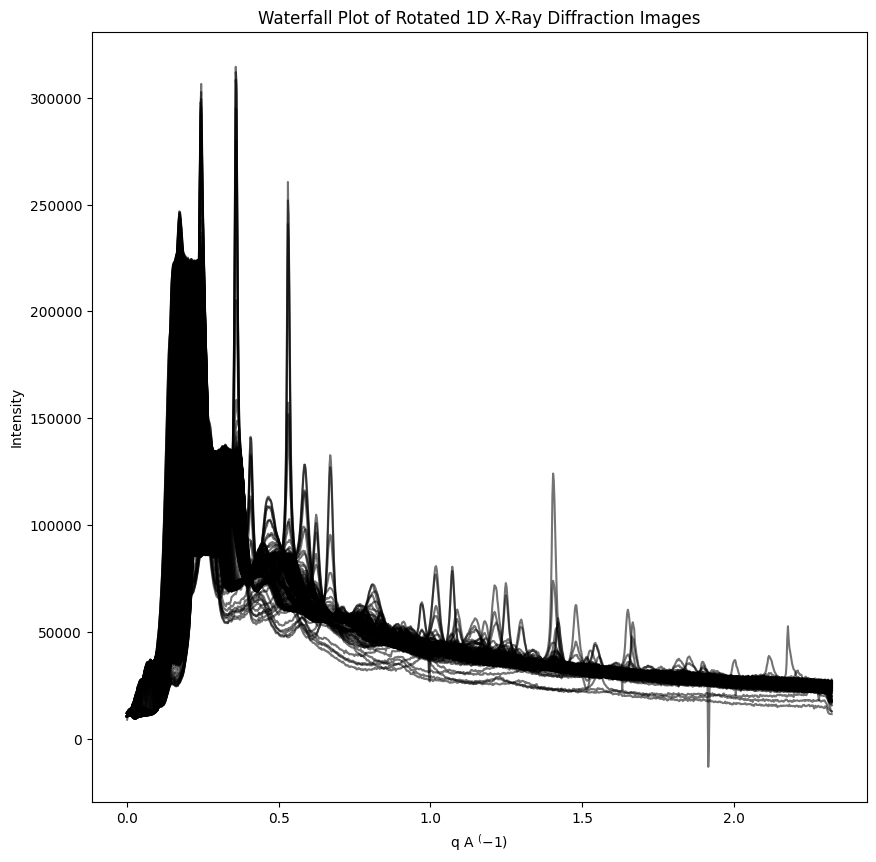

In [207]:
q, GST_6C_real_0035_nanmean_mask7 = rotate_and_integrate(gz_filled_with_mean, 1, .4179, 1.222e-10, resolution = 1000, mask = mask_7)

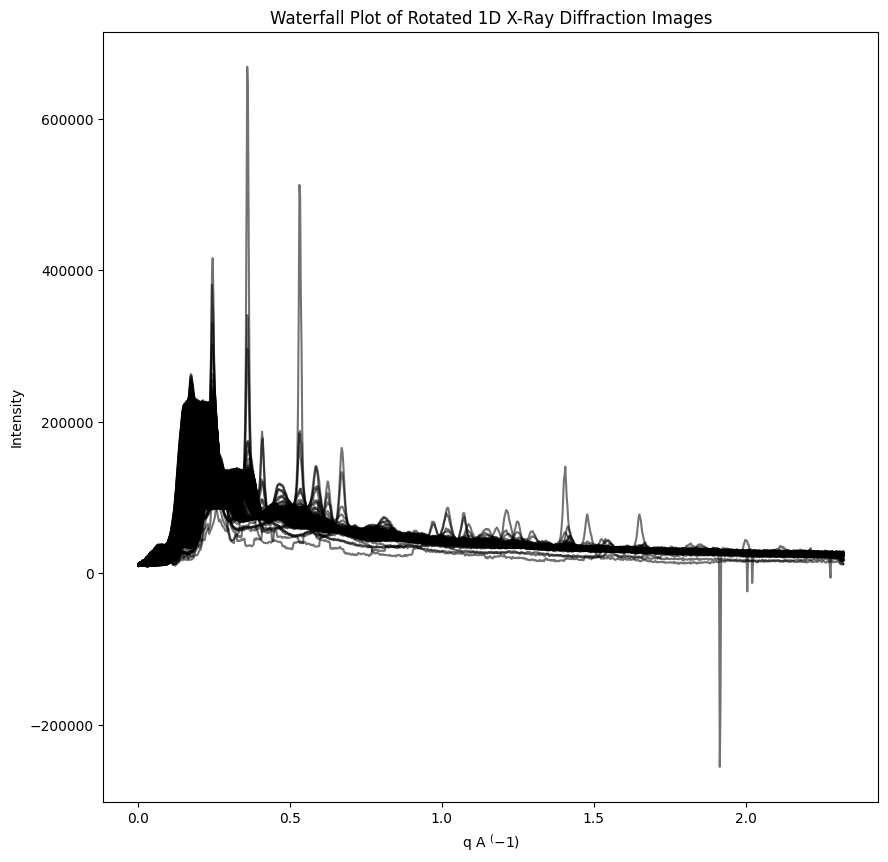

In [208]:
q, GST_6C_real_0035_nanmean_mask1 = rotate_and_integrate(gz_filled_with_mean, 1, .4179, 1.222e-10, resolution = 1000, mask = mask_1)

Input data shape: (1000, 360)

Testing 2 clusters:
The beta-divergence is:  525239000.0 %
 The final number of components used were 29 



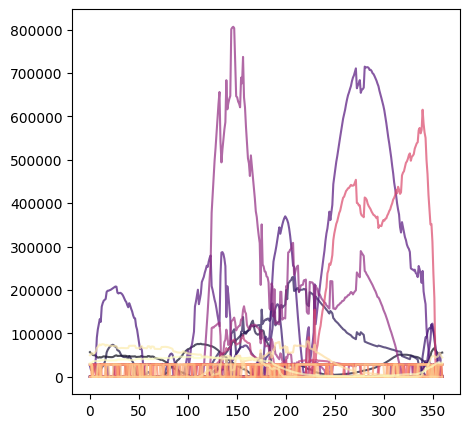

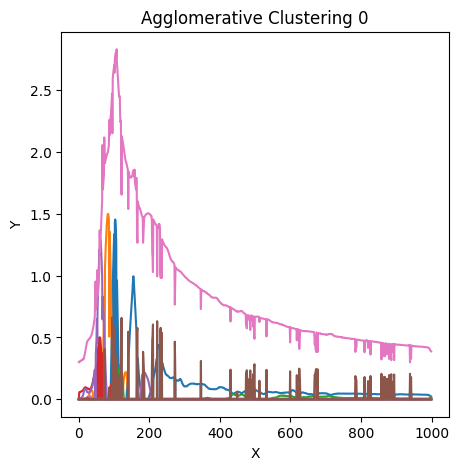

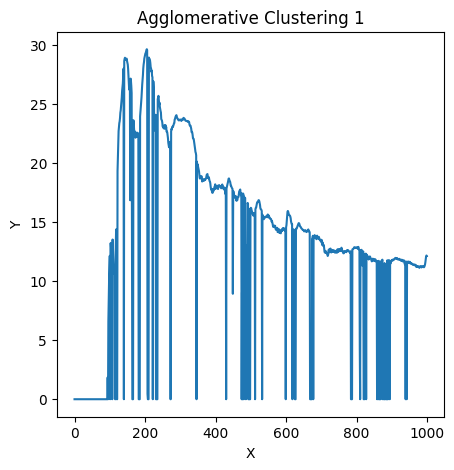

Error calculating scores: Number of labels is 28. Valid values are 2 to n_samples - 1 (inclusive)
eval_data shape: (28, 1000)
cluster_labels shape: (28,)

Testing 3 clusters:
The beta-divergence is:  525209250.0 %
 The final number of components used were 29 



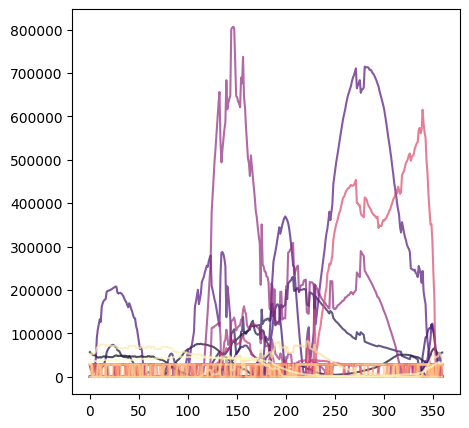

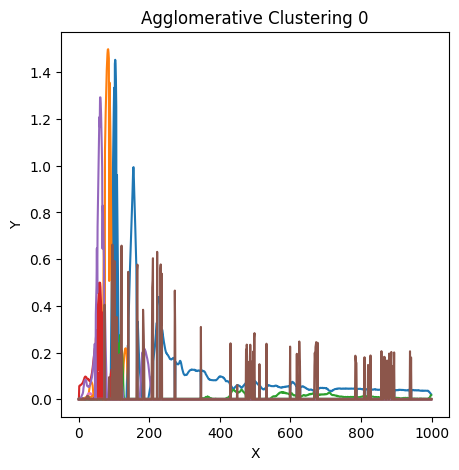

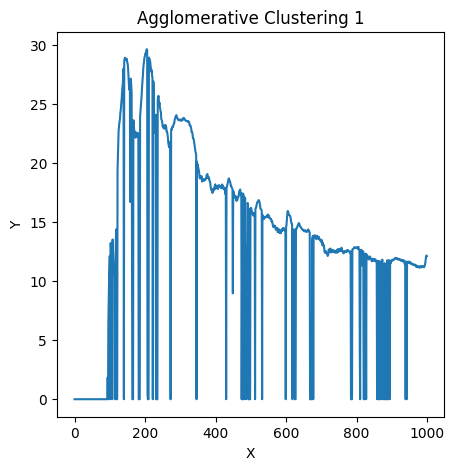

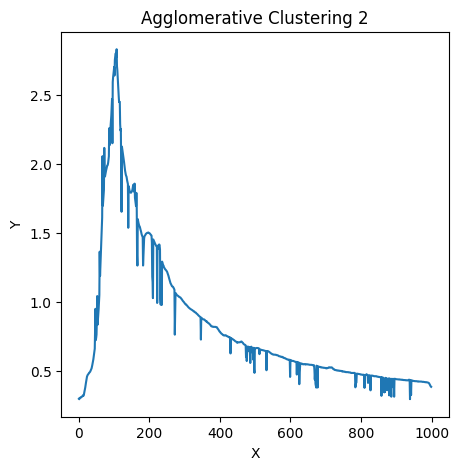

Error calculating scores: Number of labels is 28. Valid values are 2 to n_samples - 1 (inclusive)
eval_data shape: (28, 1000)
cluster_labels shape: (28,)

Testing 4 clusters:
The beta-divergence is:  525213700.0 %
 The final number of components used were 29 



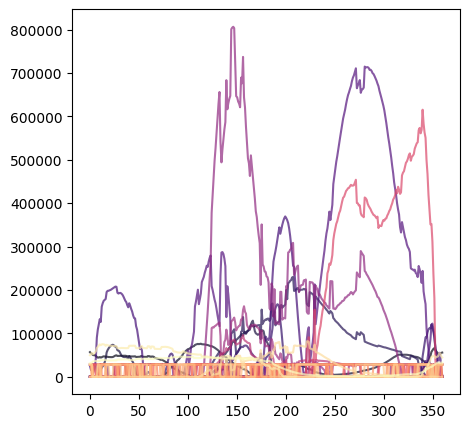

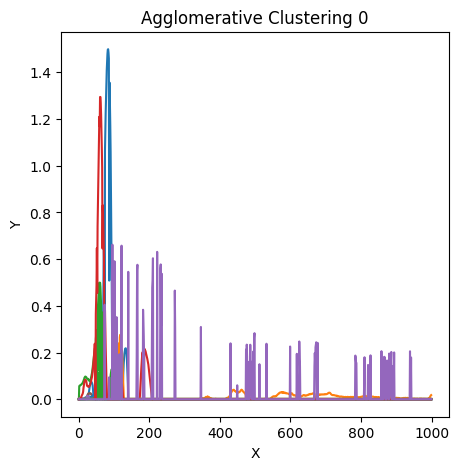

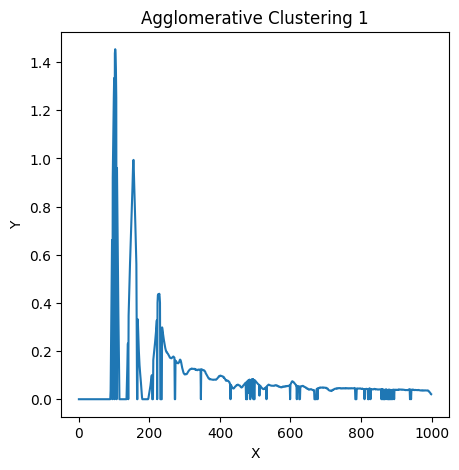

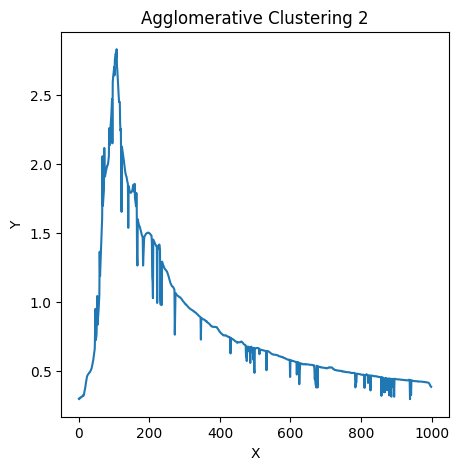

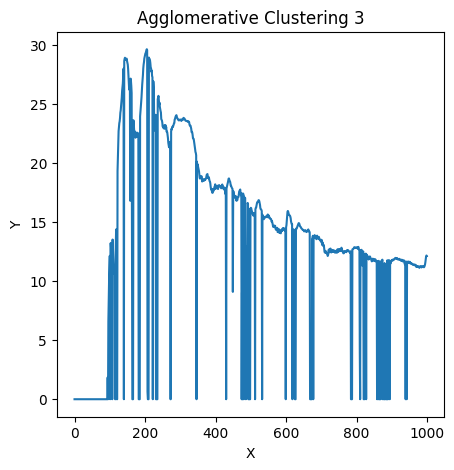

Error calculating scores: Number of labels is 28. Valid values are 2 to n_samples - 1 (inclusive)
eval_data shape: (28, 1000)
cluster_labels shape: (28,)

Testing 5 clusters:
The beta-divergence is:  525234600.0 %
 The final number of components used were 29 



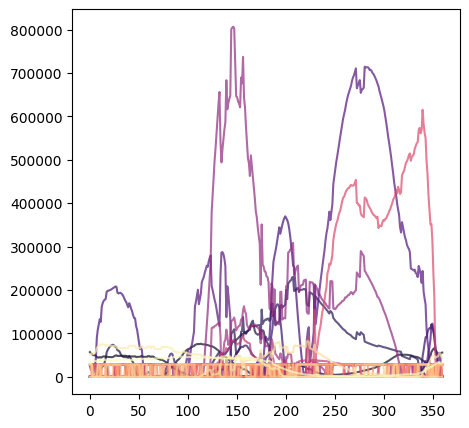

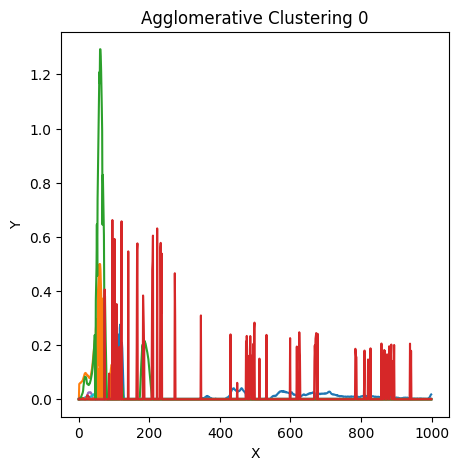

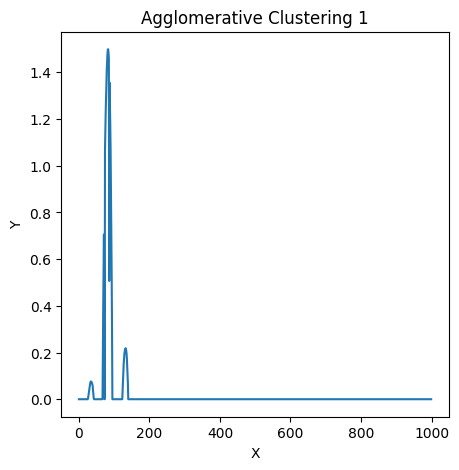

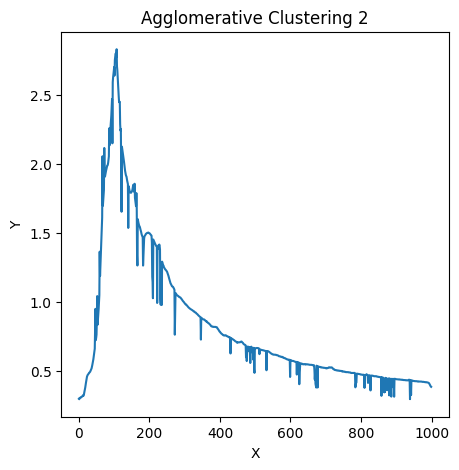

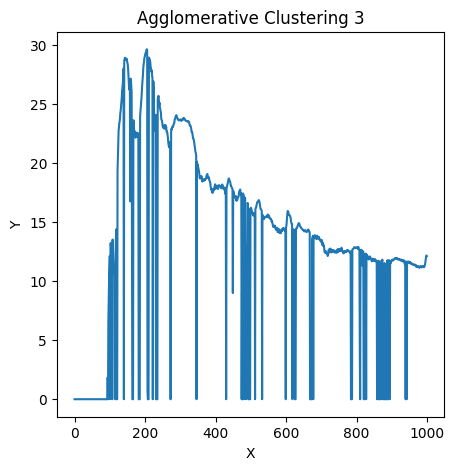

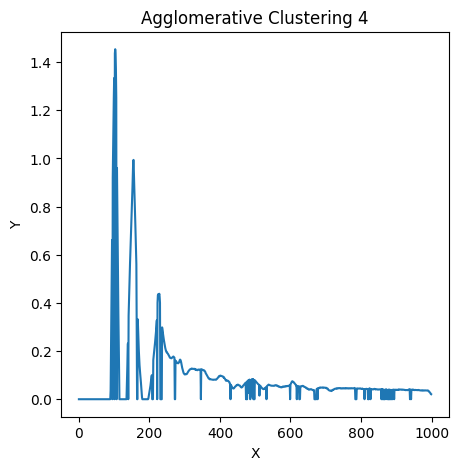

Error calculating scores: Number of labels is 28. Valid values are 2 to n_samples - 1 (inclusive)
eval_data shape: (28, 1000)
cluster_labels shape: (28,)

Testing 6 clusters:
The beta-divergence is:  525219800.0 %
 The final number of components used were 29 



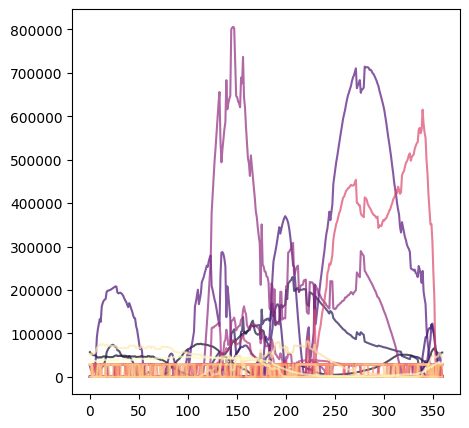

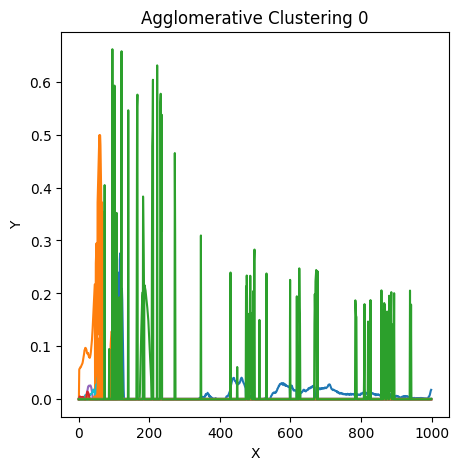

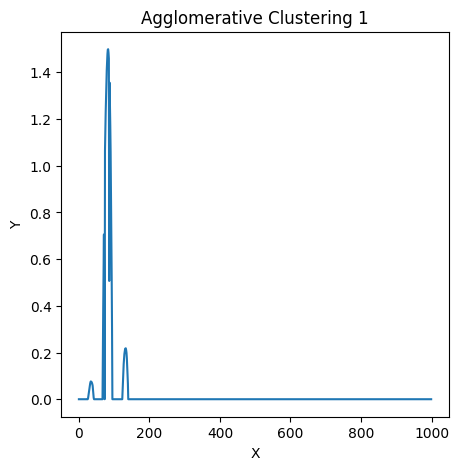

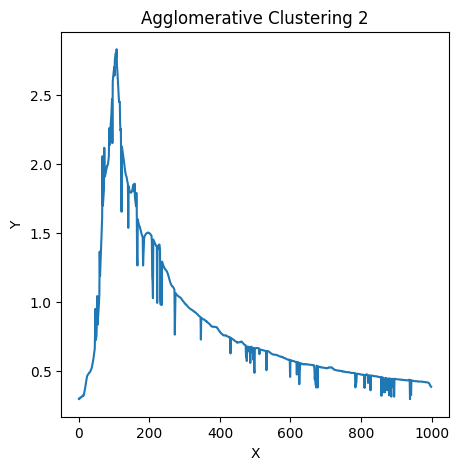

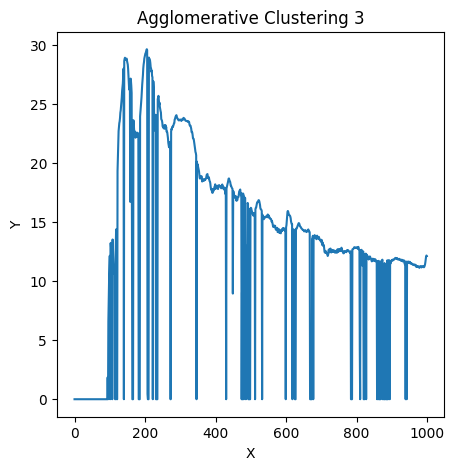

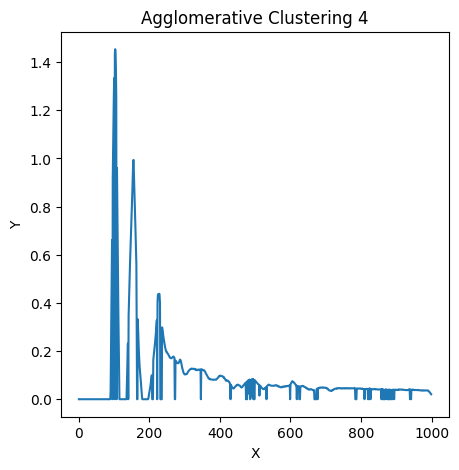

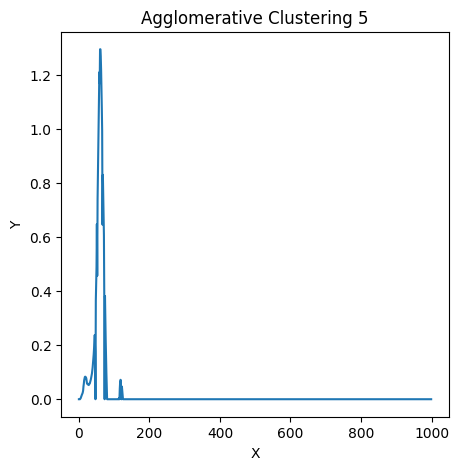

Error calculating scores: Number of labels is 28. Valid values are 2 to n_samples - 1 (inclusive)
eval_data shape: (28, 1000)
cluster_labels shape: (28,)

Testing 7 clusters:
The beta-divergence is:  525230400.0 %
 The final number of components used were 29 



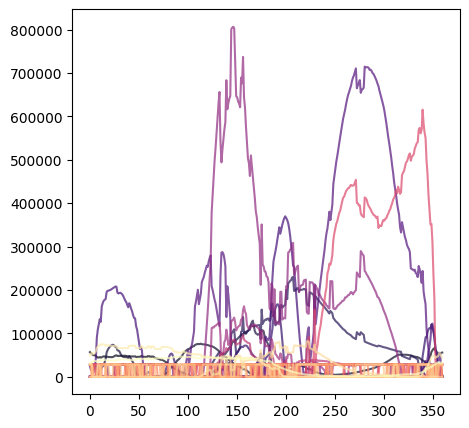

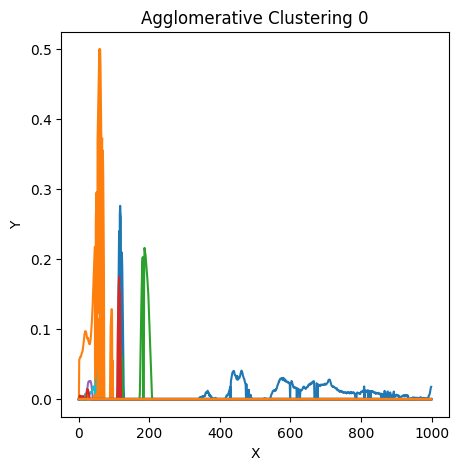

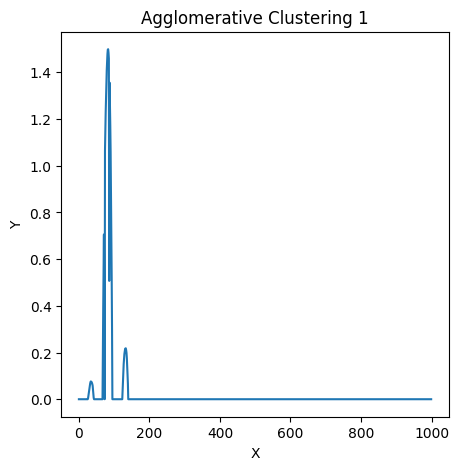

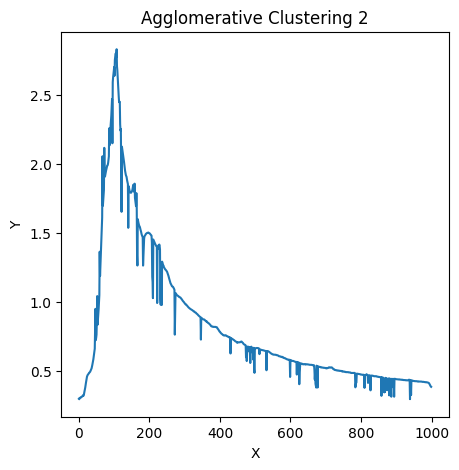

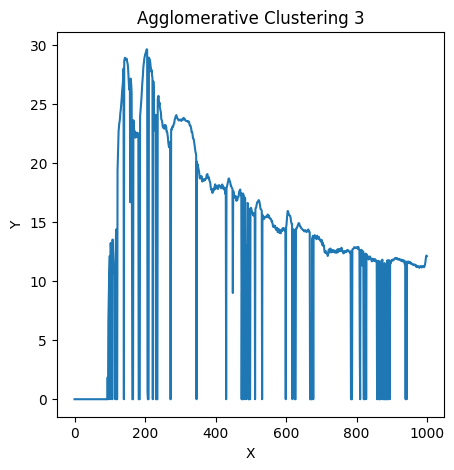

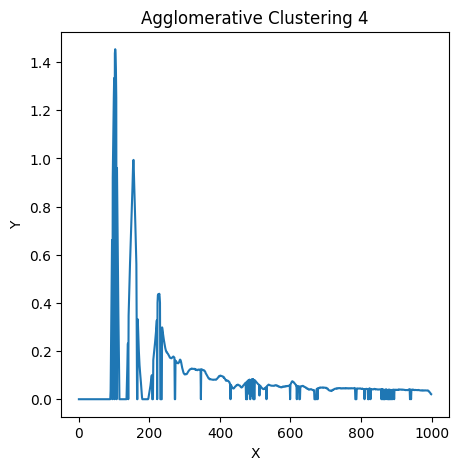

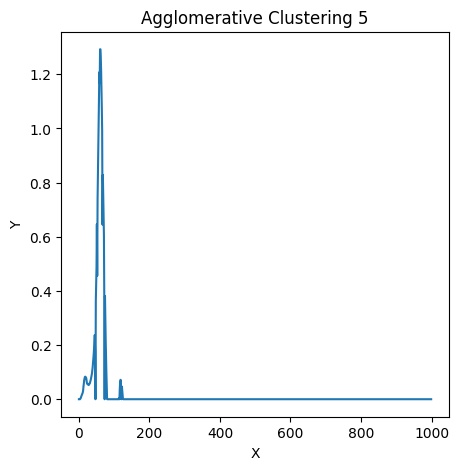

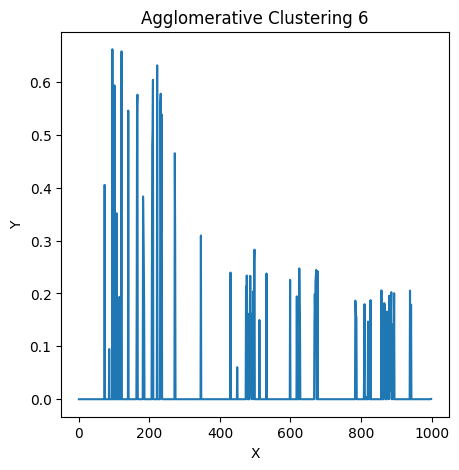

Error calculating scores: Number of labels is 28. Valid values are 2 to n_samples - 1 (inclusive)
eval_data shape: (28, 1000)
cluster_labels shape: (28,)

Testing 8 clusters:
The beta-divergence is:  525235600.0 %
 The final number of components used were 29 



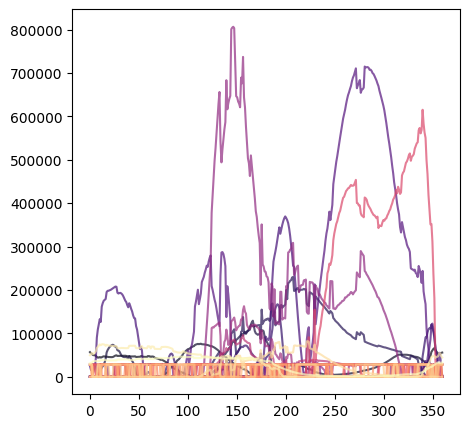

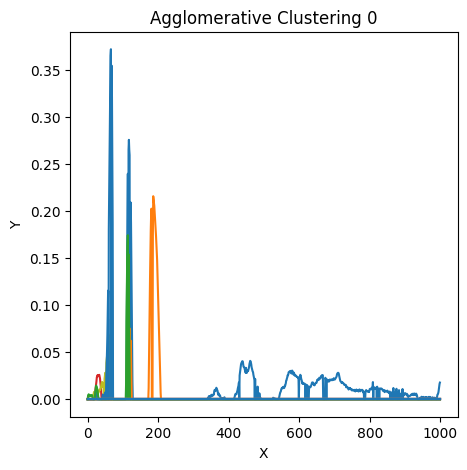

KeyboardInterrupt: Interrupted by user

In [187]:
def evaluate_clustering(data, n_clusters_range=range(2, 15)):
    """
    Evaluate clustering with proper data reshaping
    """
    results = {}
    
    # Print input data shape for debugging
    print("Input data shape:", data.shape)
    
    for n_clusters in n_clusters_range:
        print(f"\nTesting {n_clusters} clusters:")
        
        # Run your NMF clustering
        result = iso.run_nmfac(data, clusters=n_clusters)
        
        # Convert result to numpy array if it isn't already
        result_array = np.array(result)
        
        # Reshape data for evaluation if needed
        # Assuming your data is a time series or spectral data
        eval_data = result_array.reshape(len(result_array), -1)
        
        # Create cluster labels
        cluster_labels = np.arange(len(result_array))
        
        # Calculate clustering metrics only if we have enough clusters
        if len(np.unique(cluster_labels)) > 1:
            try:
                sil_score = silhouette_score(eval_data, cluster_labels)
                ch_score = calinski_harabasz_score(eval_data, cluster_labels)
                
                results[n_clusters] = {
                    'silhouette': sil_score,
                    'calinski_harabasz': ch_score,
                    'components': result
                }
                
                print(f"Silhouette Score: {sil_score:.3f}")
                print(f"Calinski-Harabasz Score: {ch_score:.3f}")
            except Exception as e:
                print(f"Error calculating scores: {e}")
                print(f"eval_data shape: {eval_data.shape}")
                print(f"cluster_labels shape: {cluster_labels.shape}")
                continue
    
    return results

# Try running with the modified function
try:
    clustering_results = evaluate_clustering(GST_6C_real_0035_data_nanmean_adj)
    
    # Only create plots if we have results
    if clustering_results:
        # Plot evaluation metrics
        plt.figure(figsize=(8, 3))
        
        if any('silhouette' in res for res in clustering_results.values()):
            plt.subplot(121)
            plt.plot(list(clustering_results.keys()), 
                    [res['silhouette'] for res in clustering_results.values()], 'o-')
            plt.xlabel('Number of Clusters')
            plt.ylabel('Silhouette Score')
            plt.title('Silhouette Score vs Number of Clusters')

        if any('calinski_harabasz' in res for res in clustering_results.values()):
            plt.subplot(122)
            plt.plot(list(clustering_results.keys()), 
                    [res['calinski_harabasz'] for res in clustering_results.values()], 'o-')
            plt.xlabel('Number of Clusters')
            plt.ylabel('Calinski-Harabasz Score')
            plt.title('Calinski-Harabasz Score vs Number of Clusters')
        
        plt.tight_layout()
        plt.show()
        
        # Select optimal number of clusters if we have silhouette scores
        if any('silhouette' in res for res in clustering_results.values()):
            optimal_n_clusters = max(clustering_results.keys(), 
                                   key=lambda k: clustering_results[k]['silhouette'])
            print(f"\nOptimal number of clusters based on Silhouette score: {optimal_n_clusters}")
    
except Exception as e:
    print(f"Error in clustering evaluation: {e}")
    print("Input data shape:", GST_6C_real_0035_data_nanmean_adj.shape)

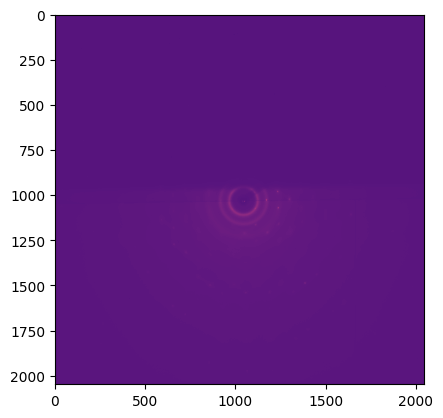

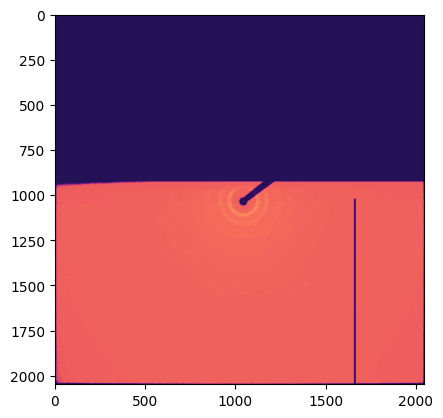

In [115]:
#check image
plt.imshow(GST_6C_real_0035_image, cmap = 'magma')
plt.show()
#check combined image
plt.imshow(gz_combined_image, cmap = 'magma')
plt.show()

In [162]:
# adjust tiff intensity
def display_enhanced_tiff(image, cmap='viridis', vmin=None, vmax=None, percentile=(2, 98)):
    plt.figure(figsize=(6, 6))
    
    # Method 1: Using percentile values for contrast
    if vmin is None or vmax is None:
        vmin, vmax = np.percentile(image, percentile)
        
    enhanced_image = image
    
    plt.imshow(enhanced_image, cmap=cmap, vmin=vmin, vmax=vmax)
    #plt.colorbar(label='Intensity')
    plt.title(f'Enhanced Image (percentile range: {percentile})')
    plt.show()
    
    # Print data range info
    print(f"Full data range: {np.min(image)} to {np.max(image)}")
    print(f"Display range: {vmin} to {vmax}")

    return enhanced_image


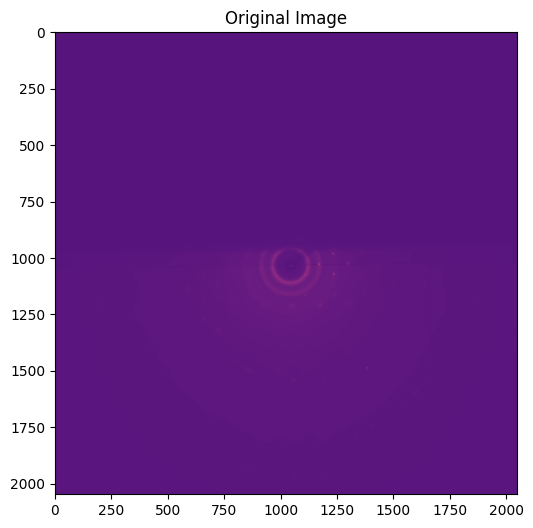

In [161]:
plt.figure(figsize=(6, 6))
plt.imshow(GST_6C_real_0035_image, cmap='magma')
plt.title(f'Original Image')
plt.show()

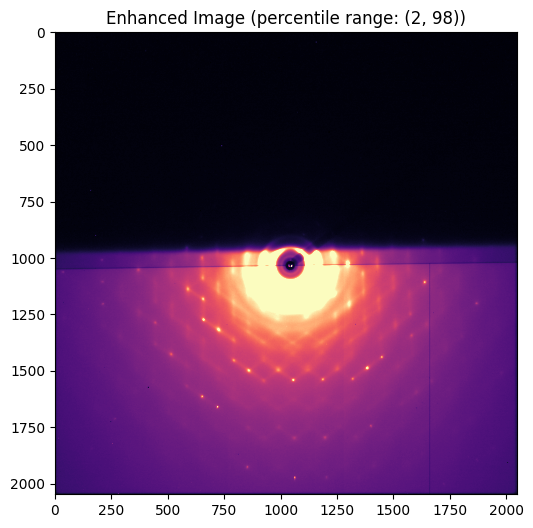

Full data range: -432640.0 to 1193701.0
Display range: -1047.0 to 66858.93999999994


array([[    0.,     0.,     0., ...,     0.,     0.,     0.],
       [ -606.,   795.,   497., ...,  -805.,   117., -1684.],
       [  179.,  -112.,  -267., ...,  1020.,  -711.,  -540.],
       ...,
       [ 3217.,  3927.,  3787., ...,  3803.,  2979.,  1985.],
       [ 3005.,  3901.,  2619., ...,  3091.,  4833.,  2346.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.]],
      dtype=float32)

In [163]:
display_enhanced_tiff(GST_6C_real_0035_image, cmap='magma')

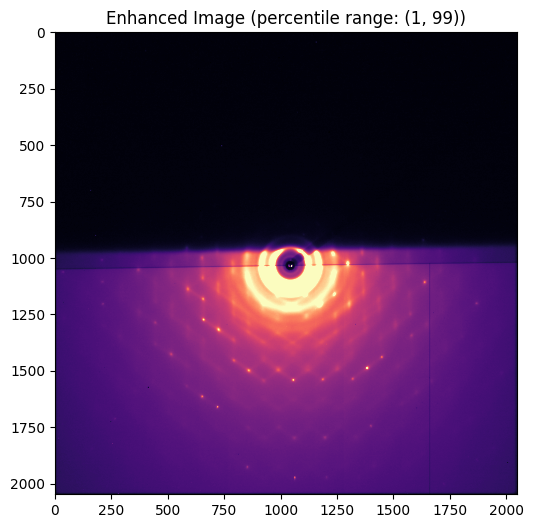

Full data range: -432640.0 to 1193701.0
Display range: -1349.0 to 81876.96999999974


array([[    0.,     0.,     0., ...,     0.,     0.,     0.],
       [ -606.,   795.,   497., ...,  -805.,   117., -1684.],
       [  179.,  -112.,  -267., ...,  1020.,  -711.,  -540.],
       ...,
       [ 3217.,  3927.,  3787., ...,  3803.,  2979.,  1985.],
       [ 3005.,  3901.,  2619., ...,  3091.,  4833.,  2346.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.]],
      dtype=float32)

In [164]:
display_enhanced_tiff(GST_6C_real_0035_image, cmap='magma', percentile=(1, 99))

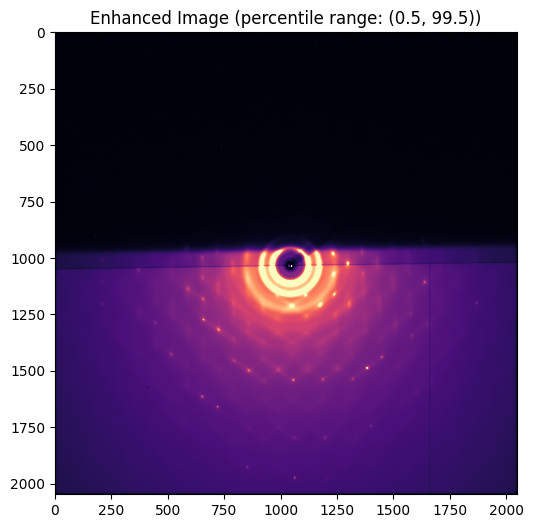

Full data range: -432640.0 to 1193701.0
Display range: -1619.0 to 99417.96999999974


array([[    0.,     0.,     0., ...,     0.,     0.,     0.],
       [ -606.,   795.,   497., ...,  -805.,   117., -1684.],
       [  179.,  -112.,  -267., ...,  1020.,  -711.,  -540.],
       ...,
       [ 3217.,  3927.,  3787., ...,  3803.,  2979.,  1985.],
       [ 3005.,  3901.,  2619., ...,  3091.,  4833.,  2346.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.]],
      dtype=float32)

In [165]:
display_enhanced_tiff(GST_6C_real_0035_image, cmap='magma', percentile=(0.5, 99.5))

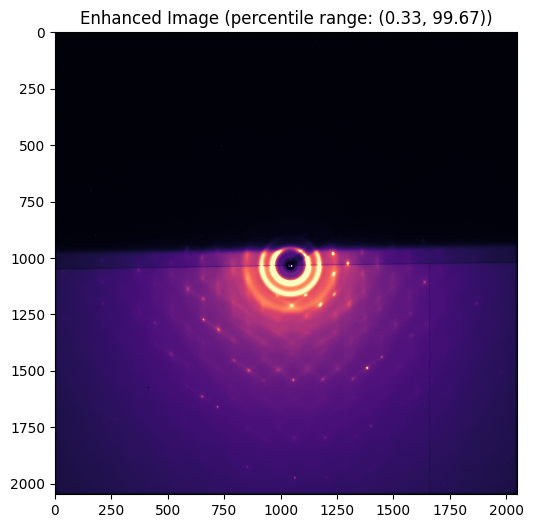

Full data range: -432640.0 to 1193701.0
Display range: -1769.0 to 115880.20040000044


array([[    0.,     0.,     0., ...,     0.,     0.,     0.],
       [ -606.,   795.,   497., ...,  -805.,   117., -1684.],
       [  179.,  -112.,  -267., ...,  1020.,  -711.,  -540.],
       ...,
       [ 3217.,  3927.,  3787., ...,  3803.,  2979.,  1985.],
       [ 3005.,  3901.,  2619., ...,  3091.,  4833.,  2346.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.]],
      dtype=float32)

In [166]:
display_enhanced_tiff(GST_6C_real_0035_image, cmap='magma', percentile=(0.33, 99.67))

In [144]:
# combine enhanced images
gz_enh_combined_image = enhanced_image + gz_scaled_mask
plt.figure(figsize=(8, 8))
plt.imshow(gz_enh_combined_image, cmap='magma')
plt.title(f'Enhanced Image + Mask')
plt.show()


NameError: name 'enhanced_image' is not defined